# Analysis of variants affecting the intacellular binding site of GPCRs

In [1]:
path_to_project="/home/martalo/Documentos/TFM/GPCR_variants"

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install bioservices
!{sys.executable} -m pip install biopython

from common_functions import *

import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import urllib

import mdtraj as md
import itertools
config(viewer='webgl')
from create_csv import * # this file is from Code/create_csv.py
import requests
import os
from matplotlib.ticker import FormatStrFormatter

/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:29: UserWarning: As of HTMD 1.16 the default ACEMD version for all protocols has changed to version 3. If you want to use version 2 protocols change the _version argument in the protocols or add `config(acemdversion=2)` to the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)
/home/martalo/miniconda3/envs/my_new_env_name/lib/python3.6/site-packages/htmd/versionwarnings.py:33: UserWarning: As of HTMD 1.16 the default number of threads HTMD spawns for calculations is set to 1. You can enable parallelism at your own risk using `config(njobs=-2)` in the beginning of your scripts. To disable this warning run once: `from htmd import _disableWarnings; _disableWarnings('1.16');`
  , UserWarning)


ffevaluate module is in beta version

Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049

HTMD Documentation at: https://www.htmd.org/docs/latest/

New devel HTMD version (1.23.2 python[3.7,<3.8.0a0,3.6,<3.7.0a0]) is available. You are currently on (1.19).There are several methods to update:    - Create a new conda env. using `conda create -n htmd1.23.2 htmd=1.23.2 -c acellera -c psi4 -c conda-forge`    - Create a brand new conda installation and run `conda install htmd -c acellera -c psi4 -c conda-forge`    - Run: `conda update htmd -c acellera -c psi4 -c conda-forge` (NOT RECOMMENDED)



## Functions 

In [45]:
def sort_gnum(gnum_li):
    '''Creates a sorted list given a list from the binding site of a PDB'''
    sorted_gnum_li=[]
    for helix in range(1,9):
        helix_li=[gnum for gnum in gnum_li if gnum.startswith(str(helix)+"x")]# if item in list starts with 1x,2x,...9x is stored in helix_li
        sorted_gnum_li+=sorted(helix_li)
        interhelix_li=[gnum for gnum in gnum_li if gnum.startswith(str(helix)+ str(helix+1)+"x")] #if item in list starts with 12x,23x,...910x
        sorted_gnum_li+=sorted(interhelix_li)
    return(sorted_gnum_li)


d={'CYSF': 'C', 'OLS': 'S', 'HE6': 'H', 'HEX': 'H', 'CCY0': 'C', 'TRP': 'W', 'TYR': 'Y', 'HEJ': 'H', 'CCY1': 'C', 'CM2L': 'K', 'HDY': 'H', 'HEB': 'H', 'CYSL': 'C', 'NCY4': 'C', 'ASN1': 'N', 'DAB': 'X', 'CCY6': 'C', 'HE4': 'H', 'CYX': 'C', 'CH2E': 'H', 'ARGN': 'R', 'CSEP': 'S', 'HES': 'H', 'ASPH': 'D', 'LYSH': 'K', 'HEG': 'H', 'CCYM': 'C', 'NASH': 'D', 'HDQ': 'H', 'GLYM': 'G', 'OLP': 'P', 'HD9': 'H', 'HS2': 'H', 'HSE': 'H', 'NCY8': 'C', 'HEL': 'H', 'HID': 'H', 'CY0': 'C', 'PTR': 'T', 'HEI': 'H', 'HEY': 'H', 'HD3': 'H', 'M2L': 'K', 'Y1P': 'Y', 'NPTR': 'T', 'HSC': 'H', 'HDT': 'H', 'NY1P': 'Y', 'MELE': 'L', 'NCY6': 'C', 'NCCS': 'C', 'CY7': 'C', 'LYS': 'K', 'ILE': 'I', 'HEC': 'H', 'CHYP': 'P', 'HEH': 'H', 'CT2P': 'T', 'KCX': 'K', 'NCY1': 'C', 'CH2D': 'H', 'NM3L': 'K', 'CACK': 'K', 'CM3L': 'K', 'ACK': 'K', 'HISA': 'H', 'HEU': 'H', 'CCY4': 'C', 'ALY': 'K', 'CASH': 'D', 'HDK': 'H', 'CCME': 'C', 'NH1E': 'H', 'HDH': 'H', 'HIS2': 'H', 'ASP': 'D', 'NCY3': 'C', 'LSN': 'K', 'HD7': 'H', 'CNLN': 'N', 'HISE': 'H', 'CS1P': 'S', 'CY8': 'C', 'NOLP': 'P', 'HSD': 'H', 'SEP': 'S', 'COLT': 'T', 'HD8': 'H', 'CSRM': 'R', 'NM2L': 'K', 'CS2P': 'S', 'HDD': 'H', 'COLS': 'S', 'HEZ': 'H', 'NCYX': 'C', 'GLUP': 'E', 'HDE': 'H', 'NTPO': 'T', 'HDS': 'H', 'NS2P': 'S', 'CCS': 'C', 'NLE': 'L', 'CY2P': 'Y', 'CY3': 'C', 'HIN': 'H', 'ASP1': 'A', 'H2E': 'H', 'HISH': 'H', 'NCY9': 'C', 'MGY': 'G', 'CH1D': 'H', 'NSRM': 'R', 'CCY9': 'C', 'NDAB': 'X', 'NNLN': 'N', 'CY6': 'C', 'CYSG': 'C', 'CHIP': 'H', 'SER': 'S', 'CDRM': 'R', 'OLT': 'T', 'LYN': 'K', 'GLY': 'G', 'NH2D': 'H', 'PHEU': 'F', 'ASN': 'N', 'HET': 'H', 'HDO': 'H', 'HD4': 'H', 'HEE': 'H', 'HE7': 'H', 'DHSE': 'H', 'HE3': 'H', 'CDAB': 'X', 'MLYS': 'K', 'NLN': 'N', 'HEP': 'H', 'MLEU': 'L', 'Y2P': 'Y', 'CGUP': 'E', 'NT2P': 'T', 'CY9': 'C', 'T1P': 'T', 'HIS1': 'H', 'HDV': 'H', 'HDB': 'H', 'HIS': 'H', 'HEM': 'H', 'HDX': 'H', 'M3L': 'K', 'HDW': 'H', 'HDZ': 'H', 'GLUH': 'E', 'GLH': 'E', 'MEVA': 'V', 'SERD': 'S', 'CHID': 'H', 'DRM': 'R', 'HEO': 'H', 'CKCX': 'K', 'NCY0': 'C', 'HEF': 'H', 'CCY5': 'C', 'NCY7': 'C', 'NHYP': 'P', 'NY2P': 'Y', 'HE0': 'H', 'CMLY': 'K', 'MVAL': 'V', 'H2D': 'H', 'SRM': 'R', 'HDC': 'H', 'NT1P': 'T', 'NHID': 'H', 'CARM': 'R', 'HE5': 'H', 'TPO': 'T', 'HDU': 'H', 'LEU': 'L', 'GLU': 'E', 'CTPO': 'T', 'HEK': 'H', 'HE2': 'H', 'MEL': 'L', 'S2P': 'S', 'HDN': 'H', 'CGU': 'E', 'HD5': 'H', 'HD6': 'H', 'AP1': 'D', 'S1P': 'S', 'DHSP': 'H', 'NACK': 'K', 'GLN': 'Q', 'NARM': 'R', 'NCY2': 'C', 'CYS': 'C', 'ARG': 'R', 'HYP': 'P', 'CY1': 'C', 'NHIN': 'H', 'CYSH': 'C', 'HD0': 'H', 'NLYN': 'K', 'NHIP': 'H', 'CY5': 'C', 'CH1E': 'H', 'HDL': 'H', 'HEA': 'H', 'NDRM': 'R', 'NCME': 'C', 'NCYM': 'C', 'CY2': 'C', 'CHIN': 'H', 'HDR': 'H', 'COLP': 'P', 'CCYX': 'C', 'CGLH': 'E', 'MEV': 'V', 'CYS2': 'C', 'HER': 'H', 'HEW': 'H', 'HEQ': 'H', 'HED': 'H', 'ZAFF': 'D', 'HISP': 'H', 'HISD': 'H', 'NGLH': 'E', 'HEV': 'H', 'HDJ': 'H', 'CY1P': 'Y', 'HDM': 'H', 'CY4': 'C', 'THR': 'T', 'NMLY': 'K', 'HDI': 'H', 'MLY': 'K', 'HEN': 'H', 'NSEP': 'S', 'H1D': 'H', 'MET': 'M', 'HIE': 'H', 'NKCX': 'K', 'HD1': 'H', 'NOLT': 'T', 'T2P': 'T', 'ALA': 'A', 'HD2': 'H', 'DHSD': 'H', 'HDP': 'H', 'CYM': 'C', 'HDF': 'H', 'HDA': 'H', 'NS1P': 'S', 'CHIE': 'H', 'CLYN': 'K', 'HISB': 'H', 'ARM': 'R', 'CT1P': 'T', 'CPTR': 'T', 'HSP': 'H', 'CME': 'C', 'HE1': 'H', 'CYSD': 'C', 'PHE': 'F', 'NH2E': 'H', 'CCY3': 'C', 'NH1D': 'H', 'NCY5': 'C', 'PRO': 'P', 'HIP': 'H', 'NHIE': 'H', 'ASPP': 'D', 'CCCS': 'C', 'HE8': 'H', 'VAL': 'V', 'HE9': 'H', 'CYSP': 'C', 'NOLS': 'S', 'CCY2': 'C', 'CCY7': 'C', 'ASH': 'D', 'TRPU': 'W', 'CCY8': 'C', 'HDG': 'H', 'H1E': 'H','CYS':'C', 'ASP':'D', 'SER':'S', 'GLN':'Q', 'LYS':'K', 'ILE':'I', 'PRO':'P', 'THR':'T', 'PHE':'F', 'ASN':'N', 'GLY':'G', 'HIS':'H', 'LEU':'L', 'ARG':'R', 'TRP':'W', 'ALA':'A', 'VAL':'V', 'GLU':'E', 'TYR':'Y', 'MET':'M', 'DCYS':'C', 'DASP':'D', 'DSER':'S', 'DGLN':'Q', 'DLYS':'K', 'DILE':'I', 'DPRO':'P', 'DTHR':'T', 'DPHE':'F', 'DASN':'N', 'DGLY':'G', 'DHIS':'H', 'DLEU':'L', 'DARG':'R', 'DTRP':'W', 'DALA':'A', 'DVAL':'V', 'DGLU':'E', 'DTYR':'Y', 'DMET':'M', 'CCYS':'C', 'CASP':'D', 'CSER':'S', 'CGLN':'Q', 'CLYS':'K', 'CILE':'I', 'CPRO':'P', 'CTHR':'T', 'CPHE':'F', 'CASN':'N', 'CGLY':'G', 'CHIS':'H', 'CLEU':'L', 'CARG':'R', 'CTRP':'W', 'CALA':'A', 'CVAL':'V', 'CGLU':'E', 'CTYR':'Y', 'CMET':'M', 'NCYS':'C', 'NASP':'D', 'NSER':'S', 'NGLN':'Q', 'NLYS':'K', 'NILE':'I', 'NPRO':'P', 'NTHR':'T', 'NPHE':'F', 'NASN':'N', 'NGLY':'G', 'NHIS':'H', 'NLEU':'L', 'NARG':'R', 'NTRP':'W', 'NALA':'A', 'NVAL':'V', 'NGLU':'E', 'NTYR':'Y', 'NMET':'M'}
def useline2(line):
    '''returns True if line starts with ATOM, or HETATM with a resname included in the dictionary''' 
    if line.startswith('ATOM') or line.startswith('HETATM'):
        trykey=line[17:21]
        trykey=trykey.strip()
        if trykey in d.keys():
            return True
        else:
            return False #this heteroatom is not useful
    else:
        return False
    
def obtain_all_chains(pdb_name):
    '''Reads a pdb file and returns all the different chain names without repetition in a list'''
    chain_name_l=[]
    fpdb=open(pdb_name,'r')
    first=True
    for line in fpdb:
        if line.startswith('ATOM') or line.startswith('HETATM'):
            chain_name=line[21]
            if first:
                first=False
                chain_name_pre=chain_name
                chain_name_l.append(line[21])
            elif (chain_name != chain_name_pre):
                chain_name_pre=chain_name
                chain_name_l.append(line[21])
    return list(chain_name_l)


def gpcrpdb_to_pdbgpcr(gpcr_pdbaa):
    ''' Given a dictionary with the pdb data of a GPCR, coming from the corresponding
    json file, builds a dictionary: keys as positions and XxY as values of the structure'''
    pdb_gpcr={} # dict that will be filled and returned
    for gnum,pdbpos in gpcr_pdbaa.items():#iteration over the data of the pdb data in the dictionary
        # each item is a dictionary as well
        # the keys (gnum) are X.ZxY, example '4.48x48', and the values (pdbpos) are another dictionary 
        # with the information of the structure, as an example, {'chain': 'A', 'pos': '158', 'aa': 'I'}
        if "." in gnum or "x" in gnum:
            gnum=gnum_all_to_one("gpcrdb",gnum) # returns an string 'XxY', example 4x48
            pdb_gpcr[int(pdbpos["pos"])]=gnum
     #return dictionary, keys are integers with the position and values are the string (XxY)
    return pdb_gpcr

def obtain_prot_chains(pdb_name):
    '''Given a pdb, read it and returns a list with the lines corresponding to ATOM/HET
    only coniseders the usefull data from the pdb file, the structure information'''
    chain_name_s=set()
    fpdb=open(pdb_name,'r')
    for line in fpdb:
        if useline2(line): # True if the line is of one valid atom/heteroatom
            chain_name_s.add(line[21])
    return list(chain_name_s)

def change_width_h(ax, new_value) :
    ''' Changes the height of the bars of 'ax' to 'new_value' '''
    for patch in ax.patches :
        current_width = patch.get_height()
        diff = current_width - new_value
        # we change the bar height
        patch.set_height(new_value)
        
        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

def change_width_v(ax, new_value) :
    '''Changes the width of the bars of 'ax' to 'new_value' '''
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def sorted_var_info(gpcr_ibspos,gpcr_ibspos_count_df):
    gpcr_ibspos_count_df_sorted=gpcr_ibspos_count_df.sort_values(by="Count",ascending=False)
    gpcrs_sorted=list(gpcr_ibspos_count_df_sorted["GPCR"])
    
    gpcr_ibspos_sorted=pd.DataFrame(columns=inner_binding_site_gnum,index=gpcrs_sorted).fillna(value=0)
    for gpcr in gpcr_ibspos_sorted.index:
        gpcr_ibspos_sorted.loc[gpcr]= gpcr_ibspos.loc[gpcr]

    return(gpcr_ibspos_sorted,gpcr_ibspos_count_df_sorted,gpcrs_sorted)

def get_count_data(myval):
    gpcr_ibspos_count_sel=dict(zip(all_gpcrs_axes,[0]*len(all_gpcrs_axes)))
    for gpcridx in gpcr_ibspos_count_sel.keys():
        count=len([varval for varval in gpcr_ibspos.loc[gpcridx].values if varval >=myval])
        gpcr_ibspos_count_sel[gpcridx]=count
    gpcr_ibspos_count_sel_df=pd.DataFrame(list(gpcr_ibspos_count_sel.items()),
                          columns=['GPCR','Count'])

    df_sel=pd.DataFrame.from_dict(gpcr_ibspos_count_sel,orient="index").T
    return (gpcr_ibspos_count_sel_df,df_sel)

def get_count_dist(gpcr_ibspos_count_sel_df,df_sel):
    gpcr_ibspos_count_sel=df_sel.to_dict(orient="records")[0]
    abundance_dist_sel={}
    for gpcr,abundance in gpcr_ibspos_count_sel.items():
        if abundance in abundance_dist_sel:
            abundance_dist_sel[abundance]+=1
        else:
            abundance_dist_sel[abundance]=1

    minkey=min(abundance_dist_sel.keys())
    maxkey=max(abundance_dist_sel.keys())
    for mykey in range(minkey,maxkey):
        if mykey not in abundance_dist_sel:
            abundance_dist_sel[mykey]=0   
            
            
    abundance_dist_sel_df=pd.DataFrame(sorted(list(abundance_dist_sel.items()),key=lambda x: x[0]),
                          columns=['Count','GPCR num'])

    return abundance_dist_sel_df

def seriation(Z,N,cur_index):
    '''Clustering:
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):#[New]
    '''Clustering:
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    #seriated_dist = np.zeros((N,N))
    #a,b = np.triu_indices(N,k=1)
    #seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    #seriated_dist[b,a] = seriated_dist[a,b]
    
    return  res_order, res_linkage

def cluster_df(my_df):
    dist_mat_md = squareform(pdist(my_df))
    method="ward"
    res_order, res_linkage = compute_serial_matrix(dist_mat_md,method)

    df_order=[]
    for e in res_order:
        df_order.append(my_df.iloc[e].name)
    return gpcr_ibspos.loc[df_order]

def order_df_by_sorterlist(sorter,gpcr_ibspos_count_df):
    sorterIndex = dict(zip(sorter,range(len(sorter))))

    gpcr_ibspos_count_df['Rank'] = gpcr_ibspos_count_df['GPCR'].map(sorterIndex)

    #gpcr_ibspos_count_df.sort(['Player', 'Year', 'Tm_Rank'], ascending = [True, True, True], inplace = True)
    gpcr_ibspos_count_df.sort_values(by="Rank",ascending=True,inplace = True)
    gpcr_ibspos_count_df.drop('Rank', 1, inplace = True)
    return gpcr_ibspos_count_df

def create_color_scale(fileInput):
    '''Use the colors from http://www.perbang.dk/rgbgradient/ copied
    into a file to build a list of colors'''
    colorscale=[]
    fileRead=open(fileInput,'r')
    for line in fileRead:
        if len(line)>4:
            new_col="#"+line[0:-1]
            colorscale.append(new_col)
    return(colorscale)

def var_to_display_in_file(wanted_gnum,ex_gpcr="HRH2",define_pdb=False,gnum_type="gpcrdb"):#test if works
    #ex_gpcr="CCR8"
    '''Build a list of variants of the introduced GPCR in ex_gpcr, if they are in the 'wanted_gnum'
    posion and if they are non-homolous (changes the aa type)'''
    dictpath="/home/martalo/Documentos/TFM/GPCR_variants/Results/gpcr_to_pdb/"
    print(ex_gpcr)
    (var_info,all_gpcrs)=var_pos_in_pdb()# read all the variants affecting each of the GPCRs in the file /home/martalo/Documentos/TFM/GPCR_variants/Results/studied_GPCR_vars/myprot_list_strucNvar.csv
    
    if define_pdb:# by default False
        pdbname=define_pdb # read the pdb name if given
    else: # the case by default
        if "pdb" in var_info[ex_gpcr].keys(): #take the pdb name
            pdbname=var_info[ex_gpcr]["pdb"]
        else:
            print("No pdb found for %s"%ex_gpcr)
            return False
    # obtain the GPCRnum
    json_filename=pdbname+"_conv.json" 
    gpcr_pdbaa_ok=gpcr_pdb_dict_fom_json(dictpath+json_filename,gnum_type=gnum_type)

    var_for_gpcr_d={}
    for this_var in var_info[ex_gpcr]["vars"]:#iterate over the variants of the GPCR
        gnum=this_var["gpcrdb"]
        seqpos=this_var["seqN"] # ¿?¿
        if gnum:# test if the variant is the wanted position
            gnum_ok=gnum_all_to_one(gnum_type,gnum)
            if gnum_ok in gpcr_pdbaa_ok and gnum_ok==wanted_gnum:
                if check_aa_type_changed(this_var['wt_aa'],this_var['var_aa'])=="changed":
                    print(this_var)
                    return (this_var)
            else:
                continue
        elif seqpos in gpcr_pdbaa_ok:
            #print('second if')
            continue
        else:
            #print('third if')
            continue

Binding site positions of all human GPCRs 
======================

I take human class A GPCRs that are crystalized with an intracellular ligand (In Hauser et al 2018 they took all chordates, that is including all vertebrates).
After downloading the whole set of GPCRs from https://gpcrdb.org/structure/, in the file Data/intracel_binding_site/GPCRdb_structures_ibs.csv we filter the human class A with 'Signal Protein'.

In [3]:
datadir=path_to_project+"/Data/intracel_binding_site/"
gpcr_downloaded_list="GPCRdb_structures_ibs.csv"

# IMPORTANT! If a new file is downloaded from the website, remove first column, first and third row and 
# add numbers to the repited column titles, name 1, name 2, type 1, type 2.

# first read the csv file and create a list of dictionaries, each list is a row (a GPCR) containing a dictionary
# keys as the column names and values as each GPCR value
myGPCRlist=[] #list of dictionaries
keys=[]
first_line=True
with open(os.path.join(datadir,gpcr_downloaded_list), mode='r') as infile:
    reader = csv.reader(infile)
    for lines in reader: # iterate each row
        if first_line: # safe keys as the first row of the file
            keys=lines
            first_line=False
        else: # save values
            for i in range(0,25):
                aux_dic[keys[i]]=lines[i]
            myGPCRlist.append(aux_dic)
        aux_dic={}
print(myGPCRlist[3])
print(len(myGPCRlist))

{'UniProt': 'SCTR', 'IUPHAR': 'secretin', 'Receptor family': 'Glucagon', 'Class': 'B1 (Secretin)', 'Species': 'Human', 'Method': 'cryo-EM', 'PDB': '6WI9', 'Refined\nstructure': '6WI9_refined', 'Resolution': '4.3', 'Preferred\nchain': 'R', 'State': 'Active', 'Degree\nactive (%)': '100', 'Family': 'Gs', 'Subtype': 'αs', 'Note': '-', '% of Seq': '49', 'Fusion': '-', 'Antibodies': 'Nanobody-35', 'Name 1': 'Secretin pubchem chembl_ligand', 'Type 1': 'peptide', 'Function': 'Agonist', 'Name 2': 'VIP, secretin', 'Type 2': 'peptide', 'D2x50-S3x39': 'No', 'Sodium in structure': 'No'}
464


To filter the human aminergic GPCRs with intracellular ligand we use the classification descrived in https://gpcrdb.org/mutational_landscape/statistics. Then, the aminergic subfamilies are in the column 'Receptor family' of the previous csv.

In [4]:
# next we keep only the human class A GPCRs with intracellular ligand (G protein)
mystrucli_ibs=[mystruc for mystruc in myGPCRlist if (mystruc["Species"]=='Human' and mystruc["Family"]!='-' and mystruc["Class"]=='A (Rhodopsin)' )]
print('Number of human aminergic GPCRs with intracellular ligand:', len(mystrucli_ibs))

Number of human aminergic GPCRs with intracellular ligand: 28


In [5]:
# print list of PDB names and Uniprot entry name
for element in mystrucli_ibs:
    unicode=element['UniProt'].lower()+'_human'
    #print(element['PDB'],'\t',unicode)
print(mystrucli_ibs[0])#print one example

{'UniProt': 'CCR6', 'IUPHAR': 'CCR6', 'Receptor family': 'Chemokine', 'Class': 'A (Rhodopsin)', 'Species': 'Human', 'Method': 'cryo-EM', 'PDB': '6WWZ', 'Refined\nstructure': '6WWZ_refined', 'Resolution': '3.3', 'Preferred\nchain': 'R', 'State': 'Active', 'Degree\nactive (%)': '100', 'Family': 'Gi/o', 'Subtype': 'αo', 'Note': '-', '% of Seq': '59', 'Fusion': '-', 'Antibodies': 'scFv16', 'Name 1': 'C-C motif chemokine ...', 'Type 1': 'protein', 'Function': 'Agonist', 'Name 2': 'CCL20, beta-defensin...', 'Type 2': 'protein', 'D2x50-S3x39': 'No', 'Sodium in structure': 'No'}


Now we have a filtered list with the information of the GPCR dataset that we will use to compute the inner binding site positions. 

### Obtain the PDB structure of the GPCRs and the Gnum<->PDBinfo of the lower regions
First, the pdb files are stored in the folder "Data/intracel_binding_site/pdb_files_ibs/". the pdb names of the GPCRs are taken from the list of dictionaries for all the human aminergic GPCRs that have an intracellular ligand.

In [6]:
pdb_path=os.path.join(path_to_project,"Data/intracel_binding_site/pdb_files_ibs/")# pdb files -> info of the structure
dictpath=os.path.join(path_to_project,"Results/Intracel_Binding_site/gpcr_to_pdb_ibs/") # json files -> _conv.json, conversion pdbcoor <-> gnum
# Donwload the pdbs if needed
pdb_uprot={}
for struc_info in mystrucli_ibs: # iteration over all the downloaded and filtered GPCRs (jsons)
    pdbname=struc_info["PDB"]# get the pdb name from the json info
    pdb_filepath=pdb_path+pdbname+".pdb" # where the the pdb file structure will be stored
    unicode=element['UniProt'].lower()+'_human'
    #if the pdb does not exist in "Results/Intracel_Binding_site/gpcr_to_pdb_ibs/", download it in "Results/Intracel_Binding_site/gpcr_to_pdb_ibs/new"
    if not os.path.isfile(pdb_filepath):
        print("- %s not found, downloaded. Skipping computation for now.." % pdbname)
        pdb_uprot[pdbname]= unicode
        urllib.request.urlretrieve('http://files.rcsb.org/download/'+pdbname+".pdb", pdb_path+"new/"+pdbname+".pdb")
        continue # The continue statement continues with the next iteration of the loop!

Bibliography to find the intracellular ligand in the structures: previously, to find the binding site we used the conserved residue Asp3.32 as it is know to be in contact with the ligands ("to detect the ligand binding pocket of each PDB structure we can consider the ligand as 'non-protein residue closer than 5Å to the GPCR residue Asp 3.32'. This residue is selected because all opioid receptors have the same aspartate residue, which is also fully conserved in aminergic receptors; in both families the acidic side chain of Asp3.32 serves as a major salt bridge anchor critical for ligand binding and receptor activation.") 

Now, we need another strategy to locate the intracellular ligands in all the structures:

-> G Protein Selectivity Is Regulated byMultiple Intracellular Regions of GPCRs, 2002 https://www.karger.com/Article/PDF/68914
1. No  obvious sequence homology was observed even for GPCRs that couple to the same G protein subtype, and no consensus motif predictive of G protein coupling has been identified. 
2. Rather than interacting with a single region at the intracellular loop of GPCRs, G protein, which also has a globular structure, is predicted to interact simultaneously with multiple intracellular regions of GPCRs.
3. Large number of studies using mutations at the putative intracellular regions suggested that the intracellular loops are key regions for G protein coupling.
4. Using deletion mutations to find coupling regions: other kind of studies suggest multiple intracellular loops of GPCR can interact with G protein. Deletion mutations that decrease G protein coupling can result in a change in the overall folding at the intracellular regions, rather than from the lack of a region responsible for G protein coupling. It is with these uncertainties that make interpretations from deletion studies inconclusive.

-> Diverse activation pathways in class A GPCRs converge near the G-protein-coupling region, 2016 https://www.nature.com/articles/nature19107
1. When the roles of these contacts in the inactive- and active-state structures are considered together, a common re-organization of contacts upon activation becomes apparent, involving residue positions 3x46 in TM3, 6x37 in TM6 and 7x53 in TM7 (notation represents the GPCRdb numbering scheme) (Fig. 3). These contacts are proximal to the G protein-coupling region and therefore distant from the ligand-binding pocket. This finding highlights that the diverse structural changes among the receptors, which are stabilized by a range of different ligands, converge on a common set of rearrangements near the G-protein-coupling region.
2. Given the importance of positions 3x46, 6x37 and 7x53 in diverse GPCRs, we anticipate that knowledge about the conserved rearrangement of contacts will guide GPCR modelling and simulations, facilitate engineering of GPCRs and help researchers to identify disease-causing mutations in other receptors.

-> Gi- and Gs-coupled GPCRs show different modesof G-protein binding, 2018, https://www.pnas.org/content/pnas/115/10/2383.full.pdf
1. Some additional conservedresidues: two leucines (L348 and L353),which in the refined model pack against the interior surface ofTM6 in rhodopsin.
2. Residues within the β6-sheet of the Ras-like domain of Gαi contribute to the contact interface with the TM5–TM6 loop of rhodopsin 


As we have seen that there is not any conserved residue to us, we will change the strategy: using the GPCRdb, we can see that helix 8 is allways at the bottom of the protein, so we could use the bottom part of all the helixes, specially helix 5 and 6, which are the ones that reach lower positions, to find residues from other chains that are near them (they would be he G protein). To use GPCR numeration we have the files 'pdbname_conv.json' where we have the translation pdbcoor <-> GPCRnum to select the lower residues of both helix. 

1. Helix 1: from 1x51(ex https://submission.gpcrmd.org/view/90/: ALA68) increasing to the last 12xY.
2. Helix 2: from 2x47 decreasing.
3. Helix 3: 3x47 increasing and 34xY.
4. Helix 4: 4x43 decreasing.
5. Helix 5: 5x56 increasing. Large one.
6. Helix 6: 6x40 decreasing. Large one.
7. Helix 7: 7x51 increasing.
8. Helix 8: 8x49 decreasing.

In [7]:
def select_bottom_res(jsonDict):
    '''Select the lower residues of a dictionary with the translation XxY:pdbInfo'''
    bottom_res=[] #list of dictionaries
    # set the start position and True is the sense is INCREASING, False DECREASING
    helixes={1:[51,True], 2:[47,False], 3:[47,True], 4:[46,False], 5:[56,True], 6:[40,False], 7:[51,True],8:[49,False]}
    mixHelixes=['12','34']
    auxHelix={}
    for gnum,pdbpos in jsonDict.items() :# iterate over the keys of the dict gpcrnum<->pdbInfo
        if len(gnum)<4:# "skip wrong GPCRnums" this is because I didn't know how it worked
            continue
        elif len(gnum)==5 and gnum[:2] in mixHelixes: # get the valid mixed helixes
            auxHelix[gnum]=pdbpos  #save mixed gnum<-> pdbInfo of the helix
            bottom_res.append(auxHelix)
            auxHelix={}
            continue
        for helixNum,helixInfo in helixes.items(): # iterate over the helix dict            
            if int(gnum[0])==helixNum and int(gnum[-2:])==helixInfo[0]:
                auxHelix[gnum]=pdbpos  #save first gnum<-> pdbInfo of the helix
                bottom_res.append(auxHelix)
            elif int(gnum[0])==helixNum: # same helix, not the first one
                if helixInfo[1] and int(gnum[-2:])>helixInfo[0]: #increasing and bigger than the offset
                    auxHelix[gnum]=pdbpos
                    bottom_res.append(auxHelix)
                elif not helixInfo[1] and int(gnum[-2:])<helixInfo[0]:#decreasing and smaller than the offset
                    auxHelix[gnum]=pdbpos
                    bottom_res.append(auxHelix)
            auxHelix={}
       
    return(bottom_res)

In [8]:
# define the lower part of each GPCR
bottom_res_gpcrs={}
for struc_info in mystrucli_ibs:
    pdbname=struc_info["PDB"]# get the pdb name from the json info
    pdb_filepath=pdb_path+pdbname+".pdb" # where the the pdb is    
    json_filename=pdbname+"_conv.json" # json translating file of the corresponding GPCR
    gpcr_pdbaa=gpcr_pdb_dict_fom_json(dictpath+json_filename) # Opens the json file and returns a dictionary, 
    #keys as the gnum 'helix x dbnum' and value as the items of the json file

    bottom_res_gpcrs[pdbname]=select_bottom_res(gpcr_pdbaa)# Key -> pdb name of the GPCR. Value -> name of the ligand (resname), and the chain of the GPCR
# bottom_res_gpcrs[pdbname]=list({XxY1:pdbInfo1}, {XxY2:pdbInfo2},....) only of the bottom residues
for gnum in bottom_res_gpcrs['6VMS']:
    for pos in gnum:
        if pos[0]=='8':
            print(pos)
print(bottom_res_gpcrs['6VMS'])

8x49
8x47
8x48
[{'2x40': {'chain': 'R', 'aa': 'N', 'pos': '70'}}, {'12x50': {'chain': 'R', 'aa': 'L', 'pos': '65'}}, {'5x69': {'chain': 'R', 'aa': 'R', 'pos': '220'}}, {'5x67': {'chain': 'R', 'aa': 'R', 'pos': '218'}}, {'6x24': {'chain': 'R', 'aa': 'K', 'pos': '362'}}, {'7x52': {'chain': 'R', 'aa': 'I', 'pos': '425'}}, {'2x44': {'chain': 'R', 'aa': 'V', 'pos': '74'}}, {'3x55': {'chain': 'R', 'aa': 'A', 'pos': '137'}}, {'7x54': {'chain': 'R', 'aa': 'T', 'pos': '427'}}, {'7x55': {'chain': 'R', 'aa': 'T', 'pos': '428'}}, {'12x51': {'chain': 'R', 'aa': 'Q', 'pos': '66'}}, {'4x41': {'chain': 'R', 'aa': 'R', 'pos': '151'}}, {'6x29': {'chain': 'R', 'aa': 'K', 'pos': '367'}}, {'2x39': {'chain': 'R', 'aa': 'T', 'pos': '69'}}, {'5x57': {'chain': 'R', 'aa': 'V', 'pos': '208'}}, {'6x27': {'chain': 'R', 'aa': 'Q', 'pos': '365'}}, {'1x54': {'chain': 'R', 'aa': 'C', 'pos': '56'}}, {'6x38': {'chain': 'R', 'aa': 'A', 'pos': '376'}}, {'6x33': {'chain': 'R', 'aa': 'A', 'pos': '371'}}, {'3x54': {'chain': 

Now we have a dictionary 'bottom_res_gpcrs' with keys as the PDB names and values as lists (of dictionaries) with the positions (gnum and pdbcoords) forming the bottom part of the GPCRs.
    
    

### Obtain Intracellular Binding Site for each PDB
Now that all the GPCRs' PDB files are downloaded and the intracellular (bottom) regions are identified, we compute the binding site for each one, all the info will be stored in the set 'inner_binding_site_total'.

In [9]:
def obtain_inner_binding_site(pdb_filepath,not_gpcr_sel,gpcr_sel,threshold=4):
    '''Creates a dict with the GPCR residue index and chain and Gprot chain, 
    of each contact that is-closer-than/below the threshold between Gprot-GPCR(bottom)'''
    struc=md.load(pdb_filepath) # resulting trajectory, as an md.Trajectory object
    chain_name_li=obtain_all_chains(pdb_filepath)# store in the list the chains of the pdb
    binding_site={}# returned dict
    binding_site['gpcr']=[]
    binding_site['gprot']=set()
    #G protein ('no-GPCR selection)
    gprot_sel=struc.topology.select(not_gpcr_sel) # select only the 'not_gpcr_sel' ATOM indexes of the topology object
    gprot_res=[residue.index for residue in struc.atom_slice(gprot_sel).topology.residues]# list of RES index of the selected residues
    all_gprot_res=gprot_res
    #print('Not GPCR residues indexes: ', all_gprot_res)# zipear esa lista con cada uno de los GPCR res
    
    #prot
    gpcr_sel=struc.topology.select(gpcr_sel) 
    gpcr_res=[residue.index for residue in struc.atom_slice(gpcr_sel).topology.residues]
    
    
    pairs = list(itertools.product(gpcr_res, all_gprot_res)) # cartesian product, equivalent to a nested for-loop
      #[(GPCRres0,gProt0),(GPCRres0,gProt1),(GPCRres0,gProt2),(GPCRres0,gProt3),...]
    
    (dists,allres_p)=md.compute_contacts(struc, contacts=pairs, scheme="closest") 
    #Compute the min distance between the atoms of pairs of residues
    # dist: array frames x pairs, distances for each residue-residue contact in each frame of the trajectory
    # allres_p: array pairs x 2, indices of the residues involved in the contact
    dists=dists[0] # take only first row, first frame 
    i=0
    while i < len(dists): # len = number of pairs tested (all Gprot - the input GPCR residue) 
        if dists[i]*10 < threshold: # dist*10< 4
            res_ind=allres_p[i][0]# test all the rows' 1st columns-> the GPCR residues index
            res_topo=struc.topology.residue(res_ind)
            res_pdb=res_topo.resSeq
            res_chain_ind=res_topo.chain.index
            res_name=res_topo.name
            res_chain=chain_name_li[res_chain_ind]
            
            res_ind_gprot=allres_p[i][1] # the Gprot info
            res_topo_gprot=struc.topology.residue(res_ind_gprot)
            res_pdb_gprot=res_topo_gprot.resSeq
            res_chain_ind_gprot=res_topo_gprot.chain.index
            res_name_gprot=res_topo_gprot.name
            res_chain_gprot=chain_name_li[res_chain_ind_gprot]
            
            binding_site['gpcr'].append([res_pdb,res_chain])
            binding_site['gprot'].add(res_chain_gprot)# store the pdb's resindex and chain
            # of the GPCRs low part and the chain of the Gprot that are closer than 
            # the threshold 
        i+=1
    return binding_site

#### First test '3SN6'
Let's try to compute the intracellular binding site for the pdb '3SN6' as an example:

In [10]:
pdbname="3SN6"
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdbaa=open_json(dictpath+json_filename)# dict, key-> Gnum, value-> dict of pdb info
pdb_gpcr=gpcrpdb_to_pdbgpcr(gpcr_pdbaa)# dict, key-> pdb pos, value->Gnum
inner_binding_site_total=set()

ibs_gprot_chain={} # gpcr_pdbname -> [gnum, chain_of_contact_Gprot] 
ibs_gprot_chain[pdbname]=[]

#get the GPCR chain
gpcr_aux_coor = list(gpcr_pdbaa.keys())[0]
gpcr_chain_aux=gpcr_pdbaa[gpcr_aux_coor]
gpcr_chain=gpcr_chain_aux['chain']
print("The chain corresponding to the GPCR in the pdb is: ", gpcr_chain)
chain_name_li=obtain_all_chains(pdb_filepath)#chains of the pdb
gpcr_chain_id="chainid "+str(chain_name_li.index(gpcr_chain))
    
# 'G protein', not-GPCR selection: 'protein and not chain_of_the_gpcr'
gprot_sel = "protein and not (%s)" % gpcr_chain_id 
    
# GPCR selection: 
#1. Selection of the bottom region of the receptors
bottom_list_of_dicts=bottom_res_gpcrs[pdbname]
gpcr_bottom=[]# list of pdb positions of the GPCR's lower region
for dic in bottom_list_of_dicts:
    for key, value in dic.items():
        gpcr_bottom.append(value['pos'])
# 2. For each GPCR bottom residue compute 'inner_binding_site()'        
for gpcrRes in gpcr_bottom:  
    gpcr_sel="residue %s and %s" % (gpcrRes, gpcr_chain_id)
    #Compute binding pocket residues for a GPCR, in this case with 4A as treshold
    inner_binding_site=obtain_inner_binding_site(pdb_filepath,gprot_sel,gpcr_sel,4)
     # it generates a dictionary gpcr-> index, chain and grpot-> index, chain 
    if len(inner_binding_site['gpcr'])!=0:
        inner_binding_site_gnum=[pdb_gpcr[pos] for pos,chain in inner_binding_site['gpcr'] if pos in pdb_gpcr]
        if len(inner_binding_site['gpcr'])!=len(inner_binding_site_gnum):
            print("%s: %i positions not considered due to lack of GPCR num."% (pdbname,len(inner_binding_site['gpcr'])-len(inner_binding_site_gnum))) 
        inner_binding_site_total=inner_binding_site_total | set(inner_binding_site_gnum)
        # save the values of the GPCR gnum and the Gprot chain that are in contact
        ibs_gprot_chain[pdbname].append([set(inner_binding_site_gnum).pop(),inner_binding_site['gprot'].pop()])
        
    inner_binding_site_gnum=[]

The chain corresponding to the GPCR in the pdb is:  R


In [11]:
# organize the GPCRnum and Gprot chain interaction pairs into a dictionary
gprot_chain={} # key Gprot chain, values GPCR positions interacting
for gnum_chain_list in ibs_gprot_chain[pdbname]:
    if gnum_chain_list[1] in gprot_chain:
        gprot_chain[gnum_chain_list[1]].append(gnum_chain_list[0])
    else:
        gprot_chain[gnum_chain_list[1]]=[]
        gprot_chain[gnum_chain_list[1]].append(gnum_chain_list[0])
print(gprot_chain)

{'A': ['5x69', '5x67', '3x55', '5x71', '6x33', '3x54', '5x64', '6x37', '3x50', '34x55', '34x52', '34x50', '6x32', '5x72', '5x75', '5x65', '34x54', '3x53', '6x36', '5x74', '34x53', '5x68', '34x51', '5x61'], 'B': ['12x48', '12x49']}


We can see that there are two residues from the GPCR (helix 12) that interact with the chain B of the G protein.

In [12]:
print(inner_binding_site_total)# for the case of '3SN6'
print(len(inner_binding_site_total))
helix='8'
for element in inner_binding_site_total:  # check elements of the helix 8
    if element[0]==helix: 
        print('Helix', helix, 'residue',element, 'interacts with G protein.')

{'5x72', '5x61', '6x36', '3x55', '34x55', '5x67', '6x37', '34x53', '12x49', '34x52', '5x64', '5x68', '6x33', '6x32', '5x71', '12x48', '5x65', '3x54', '34x50', '5x75', '34x54', '5x69', '34x51', '5x74', '3x50', '3x53'}
26


With the previous chunck we can review the residues of the GPCR that interact with the G protein and check how many of them we have for each helix.

##### Representation of the inner binding site of 3SN6

In [13]:
################## 4 A (26 interactions) ######################
pdbname="3SN6" 
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=gpcr_pdb_dict_fom_json(dictpath+json_filename)

mol = Molecule(pdb_filepath)
gpcr_sel="protein and chain R"
mol.reps.add(sel=gpcr_sel,color='#88E2FF',style='NewCartoon') # GPCR (no lig) in white newcartoon

gprot_sel="protein and chain A"
mol.reps.add(sel=gprot_sel,color="#700080",style='NewCartoon')

gprot_sel1="protein and chain B"
mol.reps.add(sel=gprot_sel1,color="#f00",style='licorice')


#inner BS
for gnum_pos in inner_binding_site_total:
    # select the residues that corresponds to ones of its binding site
    if gnum_pos in gpcr_pdb :
        gpcr_pdb[gnum_pos]
        mysel="(resid "+gpcr_pdb[gnum_pos]["pos"]+" and chain "+gpcr_pdb[gnum_pos]["chain"]+")"
        mol.reps.add(sel=mysel ,color="#3875B1",style='licorice')  
mol.view()

_ColormakerRegistry()

NGLWidget()

#### Determining the intracellular binding site for all the data set

In [14]:
####################### Compute if the set og GPCRs has changed #######################

# inner_binding_site_total=set()# set of XxY that conforms the intracellular binding site
# ibs_gprot_chain={} # gpcr_pdbname -> [gnum, chain_of_contact_Gprot] 
# count=1
# for pdbname in bottom_res_gpcrs.keys(): #iteration over the pdb names   
#     pdb_filepath=pdb_path+pdbname+".pdb"
#     json_filename=pdbname+"_conv.json"
#     gpcr_pdbaa=open_json(dictpath+json_filename)# dict, key-> Gnum, value-> dict of pdb info
#     pdb_gpcr=gpcrpdb_to_pdbgpcr(gpcr_pdbaa)# dict, key-> pdb pos, value->Gnum
    
#     # Gprot chains interactions
#     ibs_gprot_chain[pdbname]=[]
    
#     #get the gpcr chain
#     gpcr_aux_coor = list(gpcr_pdbaa.keys())[0]
#     gpcr_chain_aux=gpcr_pdbaa[gpcr_aux_coor]
#     gpcr_chain=gpcr_chain_aux['chain']
#     print('Current pdb: ', pdbname)
#     print("The chain corresponding to the GPCR in the pdb is: ", gpcr_chain)
#     chain_name_li=obtain_all_chains(pdb_filepath)#chains of the pdb
#     gpcr_chain_id="chainid "+str(chain_name_li.index(gpcr_chain))
    
#     # G protein selection: 'protein and not chain_of_the_gpcr'
#     gprot_sel = "protein and not (%s)" % gpcr_chain_id # use chainid is ok????
    
#     # GPCR selection: the selection of the bottom region of the receptors
#     bottom_list_of_dicts=bottom_res_gpcrs[pdbname]
#     gpcr_bottom=[]# list of pdb positions of the GPCR's bottom region
#     for dic in bottom_list_of_dicts:
#         for key, value in dic.items():
#             gpcr_bottom.append(value['pos'])
#     # for each GPCR bottom residue compute inner_binding_site        
#     for gpcrRes in gpcr_bottom:  
#         gpcr_sel="residue %s and %s" % (gpcrRes, gpcr_chain_id)
#         #Compute binding pocket residues for a GPCR, in this case with 5 Angstroms as treshold
#         inner_binding_site=obtain_inner_binding_site(pdb_filepath,gprot_sel,gpcr_sel,4)
#         # it generates a list of residues of the GPCR 
        
#         if len(inner_binding_site['gpcr'])!=0:
#             inner_binding_site_gnum=[pdb_gpcr[pos] for pos,chain in inner_binding_site['gpcr'] if pos in pdb_gpcr]
#             if len(inner_binding_site['gpcr'])!=len(inner_binding_site_gnum):
#                 print("%s: %i positions not considered due to lack of GPCR num."% (pdbname,len(inner_binding_site['gpcr'])-len(inner_binding_site_gnum))) 
#             inner_binding_site_total=inner_binding_site_total | set(inner_binding_site_gnum)
#             # save the values of the GPCR gnum and the Gprot chain that are in contact
#             ibs_gprot_chain[pdbname].append([set(inner_binding_site_gnum).pop(),inner_binding_site['gprot'].pop()])   
#         inner_binding_site_gnum=[]
        
#     print(count, ' GPCRs out of ', len(bottom_res_gpcrs.keys()),' have been analyzed.')
#     count+=1
# print(inner_binding_site_total)


In [15]:
############ Avoid computing IBS residues again ##############
ibs_gprot_chain={'6WWZ': [['8x48', 'A'], ['8x47', 'A'], ['3x54', 'A'], ['5x68', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['8x49', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['6x32', 'A'], ['2x39', 'A'], ['7x56', 'A']], '6VMS': [['6x24', 'A'], ['6x29', 'A'], ['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['3x50', 'A'], ['6x28', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['34x56', 'B'], ['12x48', 'B'], ['5x65', 'A'], ['2x37', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['8x47', 'A'], ['6x36', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['6x40', 'A'], ['6x25', 'A'], ['34x51', 'A']], '6K42': [['12x51', 'B'], ['8x47', 'A'], ['6x29', 'A'], ['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['8x48', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['1x59', 'B'], ['34x55', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['12x48', 'B'], ['2x38', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['4x39', 'A'], ['34x57', 'A'], ['6x36', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6K41': [['12x51', 'B'], ['6x29', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['12x48', 'A'], ['5x65', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['6x36', 'A'], ['7x56', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6U1N': [['2x39', 'C'], ['34x52', 'C'], ['7x56', 'C'], ['34x51', 'C']], '6OMM': [['6x33', 'A'], ['3x54', 'A'], ['5x68', 'A'], ['5x64', 'A'], ['3x50', 'A'], ['8x48', 'A'], ['2x43', 'A'], ['34x55', 'A'], ['8x49', 'A'], ['34x50', 'A'], ['4x40', 'A'], ['6x32', 'A'], ['5x65', 'A'], ['34x54', 'A'], ['7x53', 'A'], ['3x53', 'A'], ['4x39', 'A'], ['8x47', 'A'], ['6x36', 'A'], ['2x39', 'A'], ['7x56', 'A'], ['34x51', 'A']], '6LI3': [['5x69', 'A'], ['6x38', 'A'], ['3x54', 'A'], ['2x36', 'A'], ['3x50', 'A'], ['6x37', 'A'], ['5x73', 'A'], ['34x50', 'A'], ['12x48', 'B'], ['5x72', 'A'], ['5x66', 'A'], ['2x37', 'A'], ['34x54', 'A'], ['2x39', 'A'], ['3x49', 'A'], ['34x51', 'A']], '6UP7': [['2x35', 'B'], ['12x51', 'B'], ['6x33', 'B'], ['3x54', 'B'], ['2x36', 'B'], ['6x29', 'B'], ['34x50', 'B'], ['34x54', 'B'], ['12x49', 'B'], ['8x47', 'B'], ['8x49', 'B'], ['6x30', 'B'], ['2x34', 'B']], '6KPG': [['6x33', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['8x49', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['5x72', 'A'], ['5x75', 'A'], ['2x37', 'A'], ['3x53', 'A'], ['6x36', 'A'], ['2x39', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['3x49', 'A'], ['34x51', 'A']], '6PT0': [['2x40', 'A'], ['6x24', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['2x36', 'B'], ['8x48', 'A'], ['6x37', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x52', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['34x56', 'A'], ['12x48', 'B'], ['5x72', 'A'], ['6x26', 'A'], ['2x37', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['5x71', 'A'], ['6x36', 'A'], ['2x39', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['3x49', 'A'], ['34x51', 'A']], '6KPF': [['2x40', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['2x36', 'B'], ['6x37', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['8x49', 'A'], ['34x52', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['12x48', 'B'], ['5x72', 'A'], ['2x37', 'A'], ['3x53', 'A'], ['5x71', 'A'], ['12x49', 'B'], ['6x36', 'A'], ['2x39', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['34x51', 'A']], '6PWC': [['12x51', 'A']], '6NI3': [['5x69', 'A'], ['3x55', 'A'], ['7x55', 'A'], ['5x71', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['5x64', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['34x50', 'A'], ['5x72', 'A'], ['5x65', 'A'], ['34x54', 'A'], ['12x49', 'B'], ['6x36', 'A'], ['5x74', 'A'], ['5x68', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6OSA': [['12x50', 'A'], ['2x39', 'A'], ['3x54', 'A'], ['2x36', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['6x26', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['4x39', 'B'], ['12x49', 'A'], ['8x47', 'A'], ['8x49', 'A'], ['6x36', 'A'], ['8x48', 'A'], ['6x30', 'A'], ['7x56', 'A'], ['34x51', 'A']], '6OS9': [['2x35', 'A'], ['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['2x36', 'A'], ['6x37', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['4x40', 'A'], ['5x65', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['4x39', 'A'], ['34x57', 'A'], ['8x47', 'A'], ['5x68', 'A'], ['6x30', 'A'], ['34x51', 'A']], '6E67': [], '6OIJ': [['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['12x48', 'B'], ['5x72', 'A'], ['5x75', 'A'], ['5x65', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['6x36', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['3x49', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6OIK': [['5x69', 'A'], ['5x67', 'A'], ['6x29', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['6x28', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['12x48', 'B'], ['5x65', 'A'], ['3x53', 'A'], ['6x36', 'A'], ['7x56', 'A']], '6N4B': [['6x33', 'A'], ['3x54', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['5x75', 'A'], ['2x37', 'A'], ['3x53', 'A'], ['2x39', 'A'], ['34x53', 'A'], ['34x51', 'A']], '6G79': [['5x69', 'A'], ['6x29', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['3x50', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['8x47', 'A'], ['5x65', 'A'], ['3x53', 'A'], ['6x36', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6D9H': [['2x40', 'A'], ['5x69', 'A'], ['8x47', 'A'], ['5x71', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['5x68', 'A'], ['8x49', 'A'], ['34x50', 'A'], ['12x48', 'B'], ['5x65', 'A'], ['2x37', 'A'], ['3x53', 'A'], ['6x37', 'A'], ['7x56', 'A'], ['1x60', 'B'], ['6x25', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6CMO': [['6x24', 'A'], ['8x47', 'A'], ['8x48', 'A'], ['6x29', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['6x32', 'A'], ['5x72', 'A'], ['6x36', 'A'], ['7x56', 'A'], ['6x28', 'A'], ['6x25', 'A']], '6GDG': [['5x69', 'D'], ['3x55', 'D'], ['12x51', 'B'], ['5x71', 'D'], ['6x33', 'D'], ['3x54', 'D'], ['6x29', 'D'], ['6x37', 'D'], ['3x50', 'D'], ['34x55', 'D'], ['34x50', 'D'], ['34x52', 'D'], ['8x47', 'D'], ['12x48', 'B'], ['5x72', 'D'], ['5x65', 'D'], ['34x54', 'D'], ['3x53', 'D'], ['12x49', 'B'], ['6x36', 'D'], ['34x53', 'D'], ['8x48', 'D'], ['5x68', 'D'], ['7x56', 'D'], ['1x60', 'B'], ['34x51', 'D'], ['5x61', 'D']], '5W0P': [], '5G53': [['5x69', 'C'], ['3x55', 'C'], ['8x47', 'C'], ['5x71', 'C'], ['6x33', 'C'], ['3x54', 'C'], ['5x64', 'C'], ['6x29', 'C'], ['6x37', 'C'], ['3x56', 'C'], ['3x50', 'C'], ['34x50', 'C'], ['34x52', 'C'], ['5x72', 'C'], ['5x65', 'C'], ['3x53', 'C'], ['34x53', 'C'], ['8x48', 'C'], ['5x68', 'C'], ['7x56', 'C'], ['34x51', 'C'], ['5x61', 'C']], '5DGY': [], '4ZWJ': [], '3SN6': [['5x69', 'A'], ['5x67', 'A'], ['3x55', 'A'], ['5x71', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['5x64', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['34x52', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['12x48', 'B'], ['5x72', 'A'], ['5x75', 'A'], ['5x65', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['12x49', 'B'], ['6x36', 'A'], ['5x74', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['34x51', 'A'], ['5x61', 'A']]}

inner_binding_site_total={'5x72', '34x57', '12x49', '6x37', '8x49', '1x60', '5x64', '2x34', '5x68', '5x71', '5x69', '5x66', '12x48', '8x47', '34x56', '5x75', '3x56', '34x51', '34x55', '6x24', '7x53', '2x37', '2x39', '12x50', '3x49', '34x54', '6x25', '6x30', '34x53', '2x43', '2x40', '7x56', '2x36', '1x59', '6x38', '6x26', '5x61', '3x50', '5x73', '6x32', '6x33', '7x55', '8x48', '3x55', '4x40', '2x35', '6x36', '6x40', '3x53', '4x39', '5x67', '34x50', '5x65', '6x28', '3x54', '6x29', '12x51', '34x52', '5x74', '2x38'}
print(len(inner_binding_site_total))
print(ibs_gprot_chain)

60
{'6WWZ': [['8x48', 'A'], ['8x47', 'A'], ['3x54', 'A'], ['5x68', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['34x55', 'A'], ['8x49', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['6x32', 'A'], ['2x39', 'A'], ['7x56', 'A']], '6VMS': [['6x24', 'A'], ['6x29', 'A'], ['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['3x50', 'A'], ['6x28', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['34x56', 'B'], ['12x48', 'B'], ['5x65', 'A'], ['2x37', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['34x57', 'A'], ['8x47', 'A'], ['6x36', 'A'], ['34x53', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['6x40', 'A'], ['6x25', 'A'], ['34x51', 'A']], '6K42': [['12x51', 'B'], ['8x47', 'A'], ['6x29', 'A'], ['2x39', 'A'], ['6x33', 'A'], ['3x54', 'A'], ['8x48', 'A'], ['6x37', 'A'], ['3x50', 'A'], ['1x59', 'B'], ['34x55', 'A'], ['34x50', 'A'], ['6x32', 'A'], ['12x48', 'B'], ['2x38', 'A'], ['34x54', 'A'], ['3x53', 'A'], ['4x39', 'A'], ['34x57', 'A'], ['6x36', 'A'], ['5x68', 'A'], ['7x56', 'A'], ['34x51', 'A'], ['5x61', 'A']], '6K41': [['12x51', 

In [16]:
# organize the GPCRnum and Gprot chain interaction pairs into a dictionary for all GPCRs
gprot_chains_gpcrs={} # key pdbname, value dict with chains and gnums
for pdbname in bottom_res_gpcrs.keys():
    gprot_chain={} # key Gprot chain, values GPCR positions interacting
    for gnum_chain_list in ibs_gprot_chain[pdbname]:
        if gnum_chain_list[1] in gprot_chain:
            gprot_chain[gnum_chain_list[1]].append(gnum_chain_list[0])
        else:
            gprot_chain[gnum_chain_list[1]]=[]
            gprot_chain[gnum_chain_list[1]].append(gnum_chain_list[0])
    gprot_chains_gpcrs[pdbname]=gprot_chain
print(gprot_chains_gpcrs)

{'6WWZ': {'A': ['8x48', '8x47', '3x54', '5x68', '6x37', '3x50', '34x55', '8x49', '34x54', '3x53', '34x57', '6x32', '2x39', '7x56']}, '6VMS': {'A': ['6x24', '6x29', '2x39', '6x33', '3x54', '3x50', '6x28', '34x50', '6x32', '5x65', '2x37', '34x54', '3x53', '34x57', '8x47', '6x36', '34x53', '5x68', '7x56', '6x40', '6x25', '34x51'], 'B': ['34x56', '12x48']}, '6K42': {'B': ['12x51', '1x59', '12x48'], 'A': ['8x47', '6x29', '2x39', '6x33', '3x54', '8x48', '6x37', '3x50', '34x55', '34x50', '6x32', '2x38', '34x54', '3x53', '4x39', '34x57', '6x36', '5x68', '7x56', '34x51', '5x61']}, '6K41': {'B': ['12x51'], 'A': ['6x29', '6x33', '3x54', '6x37', '3x50', '34x55', '34x50', '6x32', '12x48', '5x65', '3x53', '34x57', '6x36', '7x56', '34x51', '5x61']}, '6U1N': {'C': ['2x39', '34x52', '7x56', '34x51']}, '6OMM': {'A': ['6x33', '3x54', '5x68', '5x64', '3x50', '8x48', '2x43', '34x55', '8x49', '34x50', '4x40', '6x32', '5x65', '34x54', '7x53', '3x53', '4x39', '8x47', '6x36', '2x39', '7x56', '34x51']}, '6LI3':

In [17]:
gnum_chainB_interaction=set()
for pdbname in gprot_chains_gpcrs:
    if(len(gprot_chains_gpcrs[pdbname]))==2:# contact with two chains 
        aux_dic=gprot_chains_gpcrs[pdbname]
        print(pdbname)
        if 'A' in aux_dic and 'B' in aux_dic and len(aux_dic['A']) > len(aux_dic['B']):            
            print(aux_dic['B'])
            for element in aux_dic['B']:
                gnum_chainB_interaction.add(element)
        elif 'A' in aux_dic and 'B' in aux_dic and len(aux_dic['A']) < len(aux_dic['B']):
            print(aux_dic['A'])
            for element in aux_dic['A']:
                gnum_chainB_interaction.add(element)
        elif 'D' in aux_dic and 'B' in aux_dic and len(aux_dic['D']) > len(aux_dic['B']):
            print(aux_dic['B'])
            for element in aux_dic['B']:
                gnum_chainB_interaction.add(element)
        elif 'D' in aux_dic and 'B' in aux_dic and len(aux_dic['D']) < len(aux_dic['B']):
            for element in aux_dic['D']:
                gnum_chainB_interaction.add(element)            
        
print(gnum_chainB_interaction)     

6VMS
['34x56', '12x48']
6K42
['12x51', '1x59', '12x48']
6K41
['12x51']
6LI3
['12x48']
6PT0
['2x36', '12x48']
6KPF
['2x36', '12x48', '12x49']
6NI3
['12x49']
6OSA
['4x39']
6OIJ
['12x48']
6OIK
['12x48']
6D9H
['12x48', '1x60']
6GDG
['12x51', '12x48', '12x49', '1x60']
3SN6
['12x48', '12x49']
{'12x48', '34x56', '1x59', '1x60', '12x51', '12x49', '4x39', '2x36'}


In the dictionary 'gprot_chains_gpcrs' we have the information of each GPCR, of which gnums of the GPCR are in contact with which chain of the G protein. 

In the set gnum_chainB_interaction we have the position of the GPCR that interact with the 'secondary' chain of the Gprotein (most of the times the 12 helix).

In [18]:
################## 4 A (26 interactions) ######################
pdbname="6GDG" 
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=gpcr_pdb_dict_fom_json(dictpath+json_filename)

mol = Molecule(pdb_filepath)
gpcr_sel="protein and chain A"
mol.reps.add(sel=gpcr_sel,color='#88E2FF',style='NewCartoon') # GPCR (no lig) in white newcartoon

gprot_sel="protein and chain D"
mol.reps.add(sel=gprot_sel,color="#700080",style='NewCartoon')

gprot_sel1="protein and chain B"
mol.reps.add(sel=gprot_sel1,color="#f00",style='licorice')


#inner BS
for gnum_pos in inner_binding_site_total:
    # select the residues that corresponds to ones of its binding site
    if gnum_pos in gpcr_pdb :
        gpcr_pdb[gnum_pos]
        mysel="(resid "+gpcr_pdb[gnum_pos]["pos"]+" and chain "+gpcr_pdb[gnum_pos]["chain"]+")"
        mol.reps.add(sel=mysel ,color="#3875B1",style='licorice')  
mol.view()

NGLWidget()

#### Representations
6K42, 6VMS, 6OIJ: chain R -> GPCR, chain A -> binding protein G(i) subunit alpha-1

3SN6, 6NI3 : chain R -> GPCR, chain A -> binding protein G(s) subunit alpha isoforms short

6K41, 6OIK : chain R -> GPCR, chain A -> Guanine nucleotide-binding protein G(o) subunit alpha

6G79 : chain S -> GPCR, chain A -> Guanine nucleotide-binding protein G(o) subunit alpha


6U1N : chain R -> GPCR, chain C -> Beta-arrestin-1

In [19]:
inner_binding_site_gnum=list(inner_binding_site_total)
inner_binding_site_gnum=sort_gnum(inner_binding_site_gnum)
print(inner_binding_site_gnum)
print(len(inner_binding_site_gnum))

['1x59', '1x60', '12x48', '12x49', '12x50', '12x51', '2x34', '2x35', '2x36', '2x37', '2x38', '2x39', '2x40', '2x43', '3x49', '3x50', '3x53', '3x54', '3x55', '3x56', '34x50', '34x51', '34x52', '34x53', '34x54', '34x55', '34x56', '34x57', '4x39', '4x40', '5x61', '5x64', '5x65', '5x66', '5x67', '5x68', '5x69', '5x71', '5x72', '5x73', '5x74', '5x75', '6x24', '6x25', '6x26', '6x28', '6x29', '6x30', '6x32', '6x33', '6x36', '6x37', '6x38', '6x40', '7x53', '7x55', '7x56', '8x47', '8x48', '8x49']
60


In [20]:
################## 4 A (26 interactions) ######################
pdbname="3SN6" 
pdb_filepath=pdb_path+pdbname+".pdb"
json_filename=pdbname+"_conv.json"
gpcr_pdb=gpcr_pdb_dict_fom_json(dictpath+json_filename)

mol = Molecule(pdb_filepath)
gpcr_sel="protein and chain R"
mol.reps.add(sel=gpcr_sel,color="#88E2FF",style='NewCartoon') # GPCR (no lig) in white newcartoon

gprot_sel="protein and chain A"
mol.reps.add(sel=gprot_sel,color="#700080",style='NewCartoon')

gprot_sel1="protein and chain B"
mol.reps.add(sel=gprot_sel1,color="#f00",style='NewCartoon')


#inner BS
for gnum_pos in inner_binding_site_total:
    # select the residues that corresponds to the TOTAL list of residues of the ibs
    if gnum_pos in gpcr_pdb :
        gpcr_pdb[gnum_pos]
        mysel="(resid "+gpcr_pdb[gnum_pos]["pos"]+" and chain "+gpcr_pdb[gnum_pos]["chain"]+")"
        mol.reps.add(sel=mysel ,color="#3875B1",style='licorice')  
mol.view()

NGLWidget()

After converting the set to a list, end up with this list of sorted items, that are the position of the binding sites of all the studied GPCRs.
Receptors with intracellular binding site affected
====================
Now we will check if there are variants affecting the positions conforming the computed intracellular binding site. To do so, we use the file Results/studied_GPCR_vars/myprot_list_strucNvar.csv. It is build with the function 'find_variants()' in Code/create_csv.py and contains a list of 46 receptors. It contains the information of the variants detected indicating the position using Gnums. This info comes from the paper from Houser, Supplementary Table 4: 'Complete variant table of clinically relevant GPCR and functional annotations'.

After 'loading' the data of the file using the function var_pos_in_pdb(), in a tupple with the name of the GPCR and the info of the rest of the columns of the csv, we use var_to_display() to create a list for each of the 46 GPCRs with the useful information of the variants affecting the GPCRs (aa changes and those things): Example: info of the first variant affecting HTR1A -> {'affected_pred': True, 'affected_items_pred': ['sift_poloP'], 'pdb_pos': {'pos': '382', 'chain': 'A', 'aa': 'K'}, 'gpcr_num': '8x56', 'aa_type_changed': True}.

In [21]:
(var_info,all_gpcrs)=var_pos_in_pdb()
dictpath_vars=os.path.join(path_to_project,"Results/gpcr_to_pdb/")# houser's gpcrs data
pdb_path_vars=os.path.join(path_to_project,"Data/pdb_files/")# houser's gpcrs data
# Reads the file myprot_list_strucNvar.csv that contains the info of the variants detected in the GPCRs from the Houser paper (46)
# var_info contains the columns organized and all_gpcrs contains the names of the GPCRs
ibs_affected={}
print("Number of iterations:", len(all_gpcrs), '\n Names of the GPCRs with variants:', all_gpcrs)
for gpcr in all_gpcrs:#iterate over the Houser's GPCRs
    bs_var=False
    gpcr_vars=var_to_display(ex_gpcr=gpcr,dictpath=dictpath_vars) # list of variants in the GPCR
    #Build a list of variants of the introduced GPCR in ex_gpcr, it also stores if the variant changes the aa type or no
    # the json files of the Houser's 46 GPCRs are in the file "Results/gpcr_to_pdb/"
    if gpcr_vars: # if there are variants affecting the GPCR
        for var in gpcr_vars:
            if var["gpcr_num"] in inner_binding_site_gnum:#check if the variant is also in the list of residues of the inner BS 
                bs_var=True
        if bs_var:
            ibs_affected[gpcr]=gpcr_vars # store the varinat affecting positions of the IBS
print("%i of %i studied 'Hauser's GPCRs have affected the intracellular binding site"%(len(ibs_affected),len(all_gpcrs)))


Number of iterations: 46 
 Names of the GPCRs with variants: ['HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR1F', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR4', 'HTR5A', 'HTR5BP', 'HTR6', 'HTR7', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA1D', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'ADRB3', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'HRH4', 'TAAR1', 'GPR18', 'CNR2', 'MCHR1', 'CCR8', 'CXCR4', 'CX3CR1', 'FSHR', 'FFAR1', 'CALCR']
No pdb found for HTR5BP
44 of 46 studied 'Hauser's GPCRs have affected the intracellular binding site


Example of representation of intracellular binding site (IBS) variants in a GPCR
-----------------------------------------------------
Using the information of the dictionary 'ibs_affected' we can display the variants affecting the intracellular BS of the GPCRs just changing the name of the GPCR.

In [22]:
#from Variants_general/gpcr_vars_reps import create_reps_affected
gpcrs_rep=["HTR1B", "HRH3", "HRHA", "FFAR1","FSHR"]
create_reps_affected(gpcrs_rep[-5],var_info,restrict_vars=inner_binding_site_gnum,path_to_project=path_to_project).view()

NGLWidget()

The colors of the variants in this case stand for: 
1. 'interact': dark blue
2. 'ptm': orange
3. 'arrestinInt+gprotInt': green 
4. 'sodiumP': red
5. 'microSwitch': purple
6. 'DisGeNet_disease': brown
7. 'activation': pink
8. 'sift_poloP': yellow-ish green

Average BS variants affected
-----------------
Now we compute the frequency in which a variant affecting each intracellular BS position is found. To do so we use the intracellular BS affected dictionary that contains the names of the GPCRs as keys and info of the variants that are in positions present in the intracellular binding site list.

In [23]:
# using the list of inner binding site residues of all the GPCRs 'inner_binding_site_gnum'
# build the following dictionary: keys as the elements of the list
inner_binding_site_dict={el:0 for el in inner_binding_site_gnum} # set to zero all the values 

# iterate over the dictionary 'GPCRname : info of the variants in positions also in the inner binding site list'
for gpcr,gpcr_vars in ibs_affected.items():
    for var in gpcr_vars: # iterate over each variant affecting the IBS of a GPCR
        for ibs_pos in inner_binding_site_gnum: # iterate over the list of all IBS residues 
            if var["gpcr_num"] == ibs_pos:
                inner_binding_site_dict[ibs_pos]+=1 # +1 if the variant is detected in the same position for another GPCR
                
# the following dictionary contains the positions of all IBS and the % of GPCRs that have a variant there                
inner_binding_site_dict={pos:round((freq/len(all_gpcrs))*100) for pos,freq in inner_binding_site_dict.items()} 
print(inner_binding_site_dict)
print(len(inner_binding_site_dict))

{'1x59': 22, '1x60': 17, '12x48': 41, '12x49': 20, '12x50': 13, '12x51': 20, '2x34': 0, '2x35': 0, '2x36': 2, '2x37': 20, '2x38': 28, '2x39': 22, '2x40': 22, '2x43': 20, '3x49': 15, '3x50': 41, '3x53': 13, '3x54': 17, '3x55': 30, '3x56': 15, '34x50': 20, '34x51': 22, '34x52': 22, '34x53': 13, '34x54': 30, '34x55': 26, '34x56': 20, '34x57': 30, '4x39': 39, '4x40': 33, '5x61': 20, '5x64': 22, '5x65': 22, '5x66': 24, '5x67': 13, '5x68': 24, '5x69': 15, '5x71': 11, '5x72': 7, '5x73': 4, '5x74': 4, '5x75': 4, '6x24': 7, '6x25': 7, '6x26': 22, '6x28': 30, '6x29': 33, '6x30': 20, '6x32': 17, '6x33': 22, '6x36': 26, '6x37': 15, '6x38': 28, '6x40': 24, '7x53': 13, '7x55': 24, '7x56': 15, '8x47': 20, '8x48': 17, '8x49': 30}
60


We have summed for the 'Houser's' GPCRs (from the list of 46) the number of times a position of the IBS list is also a position of a variant, so the number of GPCRs of the 46 that may present a variant in each of the 61 positions defined as the IBS. So a frequency of 100 for one of the 48 positions, will mean that all the 46 GPCRs are known to present a variant in that position that is part of our IBS residue list.

Representation of variants found in the intracellular binding site colored by frequency on the structure in GPCR HTR1B used as an example --> from red to green where red is a variant not found in any GPCR and green is variant found in _len_(color_map)_  % of GPCRs.

In [24]:
def create_reps_colormap(gpcr,var_info,vars_display,color_map,rep_chains=False):
    ''' Configuration of a view of a GPCR with its varints of the BS in VDW representantion and
    color depending on the number of times the variants appear in that position for all the GPCRs'''
    name=var_info[gpcr]["name"]
    pdb=var_info[gpcr]["pdb"]
    is_model=var_info[gpcr]["is_model"] 
    affected_vars=[]
    unaffected_vars=[]
    unknown_vars=[]
    rep_chains=set()
    
    if rep_chains: 
        gpcr_sel="protein and (%s)" % " or ".join(rep_chains)
    else:
        gpcr_sel="protein"
    mypdb=pdb+".pdb"
    mypdbpath=os.path.join(pdb_path_vars,mypdb)
    mol = Molecule(mypdbpath)
    mol.reps.add(sel=gpcr_sel,color="#f4f8ff",style='NewCartoon')
    
    for var in vars_display:
        mysel="(name CA and resid "+var["pdb_pos"]+" and chain "+var["chain"]+")"
        mol.reps.add(sel=mysel ,color=color_map[var["value"]],style='VDW')
    mol.center()
    #mol.view()
    return mol
#{'interact', 'ptm', 'arrestinInt', 'sodiumP', 'microSwitch', 'DisGeNet_disease', 'activation', 'gprotInt', 'sift_poloP'}

In [25]:
gpcr="HTR1A" # using this GPCR as an example
pdbname=var_info[gpcr]["pdb"]
json_filename=pdbname+"_conv.json"
gpcr_pdb=gpcr_pdb_dict_fom_json(dictpath_vars+json_filename) # the json files of the Houser's 46 GPCRs are in the file "Results/gpcr_to_pdb/"

vars_display=[]# list containing dictionaries with the position, chain and freq of variants in the BSs
for gnum, freq in inner_binding_site_dict.items():
    ibs_var_info={}
    if gnum in gpcr_pdb:
        ibs_var_info["pdb_pos"]=gpcr_pdb[gnum]["pos"]
        ibs_var_info["chain"]=gpcr_pdb[gnum]["chain"]
        ibs_var_info["value"]=freq
        vars_display.append(ibs_var_info)
color_map=create_color_scale("/home/martalo/Documentos/TFM/GPCR_variants/Data/colors.txt")
# redish, variants not found in GPCRs, greenish present in more an more GPCRs
# then, extended color map, since #700080 (purple) to very light blue
create_reps_colormap(gpcr,var_info,vars_display,color_map).view()


NGLWidget()

In [26]:
for k,v in inner_binding_site_dict.items():
    print(k,"\t",v)
print('Total variantions in IBSs: ',len( inner_binding_site_dict))
# The fist colum is the gnum and the second is the % of GPCRs with a variation in that position

1x59 	 22
1x60 	 17
12x48 	 41
12x49 	 20
12x50 	 13
12x51 	 20
2x34 	 0
2x35 	 0
2x36 	 2
2x37 	 20
2x38 	 28
2x39 	 22
2x40 	 22
2x43 	 20
3x49 	 15
3x50 	 41
3x53 	 13
3x54 	 17
3x55 	 30
3x56 	 15
34x50 	 20
34x51 	 22
34x52 	 22
34x53 	 13
34x54 	 30
34x55 	 26
34x56 	 20
34x57 	 30
4x39 	 39
4x40 	 33
5x61 	 20
5x64 	 22
5x65 	 22
5x66 	 24
5x67 	 13
5x68 	 24
5x69 	 15
5x71 	 11
5x72 	 7
5x73 	 4
5x74 	 4
5x75 	 4
6x24 	 7
6x25 	 7
6x26 	 22
6x28 	 30
6x29 	 33
6x30 	 20
6x32 	 17
6x33 	 22
6x36 	 26
6x37 	 15
6x38 	 28
6x40 	 24
7x53 	 13
7x55 	 24
7x56 	 15
8x47 	 20
8x48 	 17
8x49 	 30
Total variantions in IBSs:  60


Receptors with the intracellular binding site affected
--------------------------------

In [27]:
all_gpcrs_axes=[]
for mygpcr,mygpcr_info in var_info.items():
    all_gpcrs_axes.append("%s (%s)" % (mygpcr_info["name"].capitalize(),mygpcr))
# build a data frame to display the heatmaps
gpcr_ibspos=pd.DataFrame(columns=inner_binding_site_gnum,index=all_gpcrs_axes).fillna(value=0)
# cols are the residues of the intracellular binding site of all GPCRs, the rows are the names of the 46 Houser GPCRs
# initially all the values of the matrix set to zero
print(all_gpcrs_axes,'\n') 
print('Total number of GPCRs(rows of heatmap): ',len(all_gpcrs_axes))

['5-hydroxytryptamine receptor 1a (HTR1A)', '5-hydroxytryptamine receptor 1b (HTR1B)', '5-hydroxytryptamine receptor 1d (HTR1D)', '5-hydroxytryptamine receptor 1e (HTR1E)', '5-hydroxytryptamine receptor 1f (HTR1F)', '5-hydroxytryptamine receptor 2a (HTR2A)', '5-hydroxytryptamine receptor 2b (HTR2B)', '5-hydroxytryptamine receptor 2c (HTR2C)', '5-hydroxytryptamine receptor 4 (HTR4)', '5-hydroxytryptamine receptor 5a (HTR5A)', '5-hydroxytryptamine receptor 5b, pseudogene (HTR5BP)', '5-hydroxytryptamine receptor 6 (HTR6)', '5-hydroxytryptamine receptor 7 (HTR7)', 'Cholinergic receptor muscarinic 1 (CHRM1)', 'Cholinergic receptor muscarinic 2 (CHRM2)', 'Cholinergic receptor muscarinic 3 (CHRM3)', 'Cholinergic receptor muscarinic 4 (CHRM4)', 'Cholinergic receptor muscarinic 5 (CHRM5)', 'Adrenoceptor alpha 1a (ADRA1A)', 'Adrenoceptor alpha 1b (ADRA1B)', 'Adrenoceptor alpha 1d (ADRA1D)', 'Adrenoceptor alpha 2a (ADRA2A)', 'Adrenoceptor alpha 2b (ADRA2B)', 'Adrenoceptor alpha 2c (ADRA2C)', 'Adr

So, now we have 46 GPCRs to work with. Next, we separate the variants in two groups, the ones that change the amino acid type and the ones that 'mantain' the amino acid type.

In [28]:
#Vars of the BS found in each GPCR
p=re.compile(".*\((\w*)\)")

for gpcrname in all_gpcrs_axes:# iteration over the GPCRs with variants in its BS
    gpcr=re.search(p,gpcrname).group(1)
    gpcr_vars=var_to_display(ex_gpcr=gpcr,dictpath=dictpath_vars) # function in 'create_csv', returns list of variats of the GPCR with information about the aa change type as well  
    if gpcr_vars:
        found_pos={}
        for var in gpcr_vars:# iteration over the variants of the BS of each GPCR
            gnum=var["gpcr_num"]
            if gnum:
                found_pos[gnum]=var["aa_type_changed"]
        for ibspos in inner_binding_site_gnum: # filling the data frame with '1' or '2'
            if ibspos in found_pos:
                aa_type_changed=found_pos[ibspos]
                if aa_type_changed:
                    gpcr_ibspos[ibspos][gpcrname]=2 # set to '2' if the aa changes
                else:
                    gpcr_ibspos[ibspos][gpcrname]=1 # set to '1' if the new aa type is similar

No pdb found for HTR5BP


Green: No variant known

Yellow: variant(s) known but all of them with a similar residue than original

Red: variant(s) known, at least one of them gives a different residue than original.

A residue is considered different if it causes a change of type:
1. aromatic
2. helix_breakers
3. hydrophobic
4. negative
5. plar_uncharged
6. positive

In [29]:
gpcr_ibspos

,1x59,1x60,12x48,12x49,12x50,12x51,2x34,2x35,2x36,2x37,...,6x36,6x37,6x38,6x40,7x53,7x55,7x56,8x47,8x48,8x49
5-hydroxytryptamine receptor 1a (HTR1A),0,0,2,0,0,0,0,0,0,1,...,2,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1b (HTR1B),2,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1d (HTR1D),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0
5-hydroxytryptamine receptor 1e (HTR1E),0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-hydroxytryptamine receptor 1f (HTR1F),0,0,2,0,0,0,0,0,0,0,...,0,1,0,2,0,2,0,0,0,0
5-hydroxytryptamine receptor 2a (HTR2A),0,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5-hydroxytryptamine receptor 2b (HTR2B),2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
5-hydroxytryptamine receptor 2c (HTR2C),0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,1,2,1
5-hydroxytryptamine receptor 4 (HTR4),0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,2
5-hydroxytryptamine receptor 5a (HTR5A),0,0,0,0,0,0,0,0,0,0,...,2,0,2,0,2,2,0,0,0,2


The matrix has 46 rows corresponding to the GPCRs and colums with the position of the residues of all the intracellular binding sites. In the matrix if the number is '2' the variant changes the AA type (will be red) and if it is '1' is does not change the AA, (yellow), '0' for non-variant (green). The next heatmap represents that matrix:

2020-10-09 12:04:45,715 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


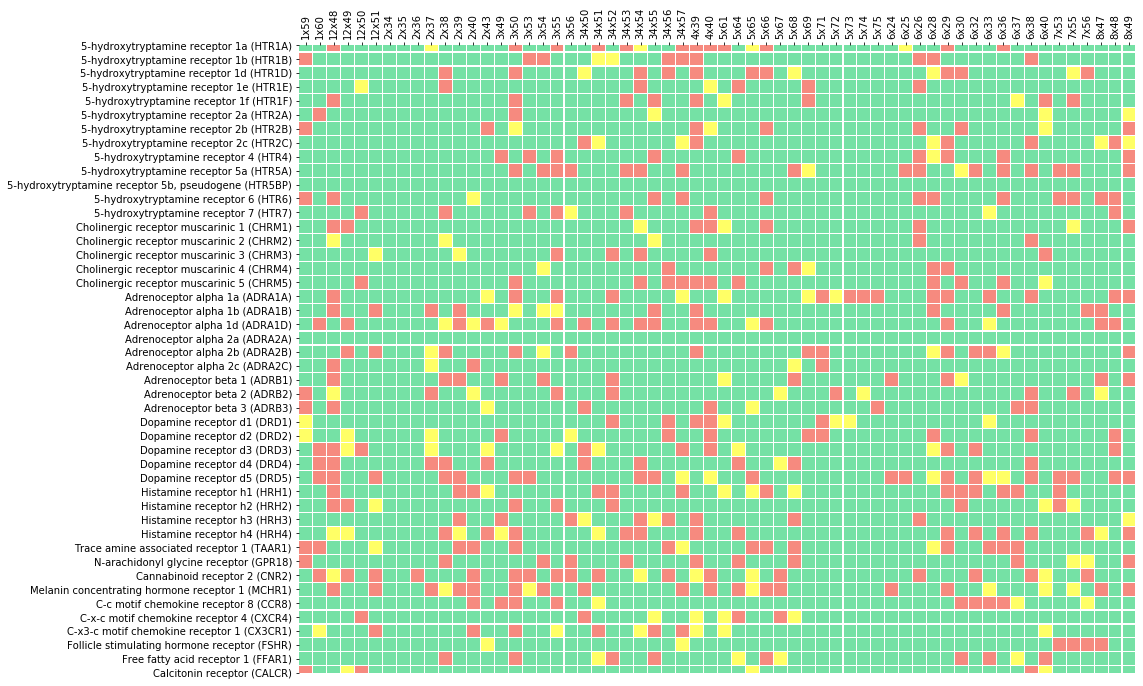

In [30]:
!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))
ax2=sns.heatmap(gpcr_ibspos, cmap=["#75E1A5","#ffff66","#F68A7F"], linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
ax2.xaxis.set_ticks_position('top')
plt.xticks(rotation=90) 
plt.show()
#plt.savefig("/home/martalo/Documentos/TFM/Pharmacogenomics/binding_site/ibs_affected2.png")

In the previous heatmap we can see if the 46 Houser's GPCR (rows) present the variant in a residue forming the intracellular BS (position in the colum) and if it changes the amino acid type (red) or not (yellow).

#### Plot with extra info:
Set variables depending on preference:

In [31]:
showvars_val=1 # set to 0 will show all variants
order_by_varnum=False # set to False will order GPCRs alphabetically

The previous parameters can take the following values:

Show barplot of all variants ('showvars_val=0') or only display non-conservative variants ('showvars_val=1').

Change 'order_by_varnum=True', to order GPCRs by number of variants of type (non-conservative or all). Otherwise (set to 'False'), order alphabetically.

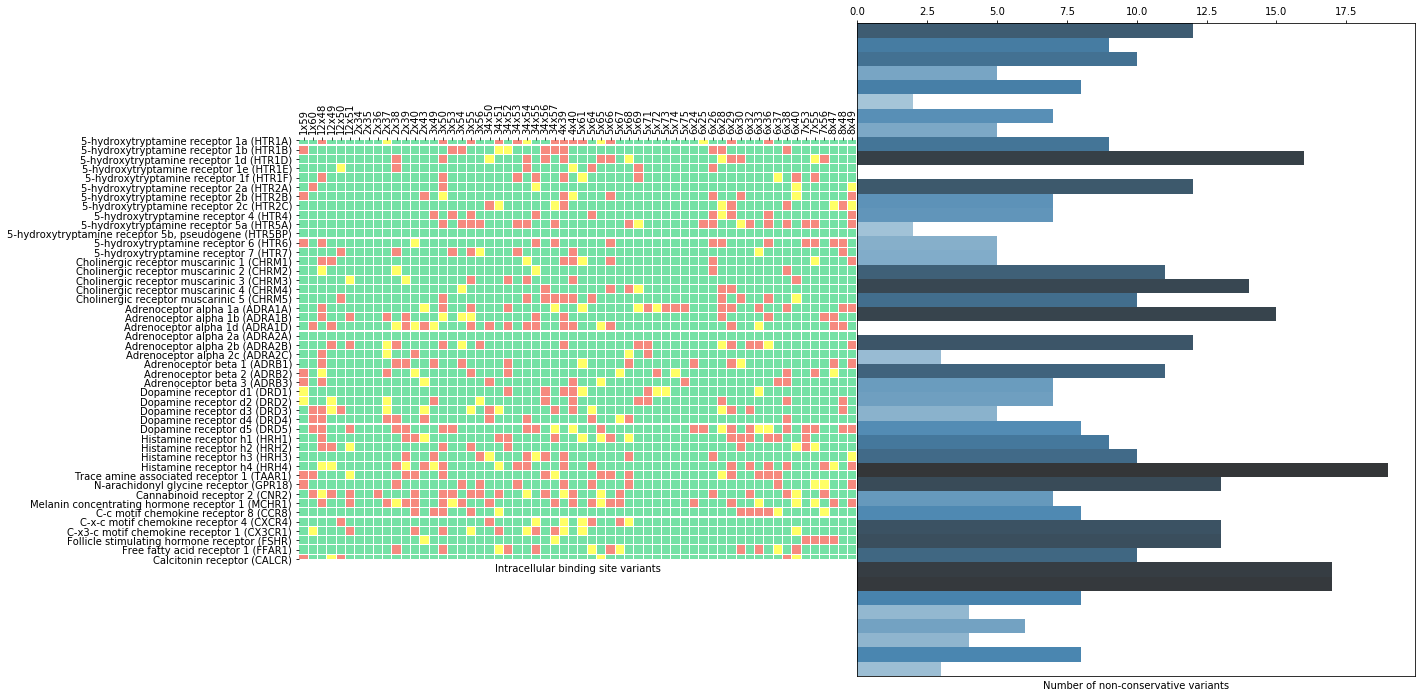

In [32]:
gpcr_ibspos_count=dict(zip(all_gpcrs_axes,[0]*len(all_gpcrs_axes)))
for gpcridx in gpcr_ibspos_count.keys():
    count=len([varval for varval in gpcr_ibspos.loc[gpcridx].values if varval >showvars_val])
    gpcr_ibspos_count[gpcridx]=count
    
gpcr_ibspos_count_df=pd.DataFrame(list(gpcr_ibspos_count.items()),
                      columns=['GPCR','Count'])

if order_by_varnum:
    (gpcr_ibspos,gpcr_ibspos_count_df,all_gpcrs_axes)=sorted_var_info(gpcr_ibspos,gpcr_ibspos_count_df)
    
# represent the data frame gpcr_ibspos as barplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
axA=sns.heatmap(gpcr_ibspos, cmap=["#75E1A5","#ffff66","#F68A7F"], linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax[0])
axA.xaxis.set_ticks_position('top')
axA.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
axA.xaxis.set_label_text("Intracellular binding site variants")
#axA.xaxis.set_label_position('top') 

#gpcr_ibspos_count_df 
pal = sns.color_palette("Blues_d", len(gpcr_ibspos_count_df))
rank = gpcr_ibspos_count_df["Count"].argsort().argsort() 
axB = sns.barplot(data=gpcr_ibspos_count_df , x="Count",y="GPCR",palette=np.array(pal[::-1])[rank])
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of non-conservative variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The barplot is added to make the sum of variants of each GPCR (I think the colors are not important here).
#### Distribution of variant abundance in our dataset 

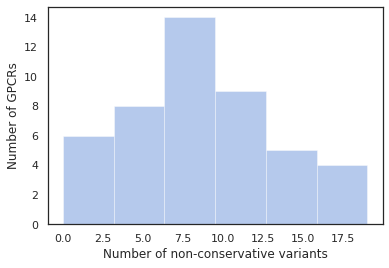

In [33]:
df=pd.DataFrame.from_dict(gpcr_ibspos_count,orient="index").T
# data = gpcr_ibspos_count -> dictionary with keys as the name of the GPCR
# and value as the number of variants it has (it depends in the selction of showvars_val as 0 or 1,
# that considers all the variants or only the ones that changes the aa type)
# parameter orient="index" means that the keys of the dictionary of 'data' should be rows (by default they are cols)
# .T = Transpose index and columns, we will do an histogram, trasposing the barplot

# Plot histogram df (data frame with name of the GPCR and number of variants )
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
ax=sns.distplot(df,  kde=False)
ax.xaxis.set_label_text("Number of non-conservative variants")# this axis name will depend on the showvars_val as 0 or 1 value
ax.yaxis.set_label_text("Number of GPCRs")

plt.show()

In this plot we cannot see the differences between the varinats that are conservatives (not changing the aa type) and non-conservative (changing aa type). We just can display the two distributions by changing the value of 'showvars_val' as 0 or 1. In the next section we make the separation.
### Same representations differencing conservative / non-conservative

In [34]:
#if order_by_varnum:
#    (gpcr_ibspos,gpcr_ibspos_count_df)=sorted_var_info(gpcr_ibspos,gpcr_ibspos_count_df)

In [35]:
(gpcr_ibspos_count_cons_df,df_cons)=get_count_data(2)
(gpcr_ibspos_count_all_df,df_all)=get_count_data(1)

abundance_dist_cons_df=get_count_dist(gpcr_ibspos_count_cons_df,df_cons)
abundance_dist_all_df=get_count_dist(gpcr_ibspos_count_all_df,df_all)

#### Distribution of variant abundance in our dataset GPCRs

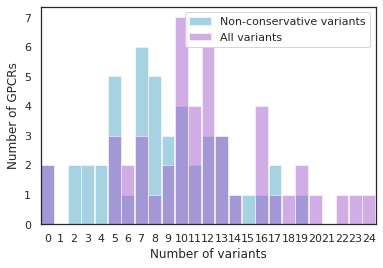

In [36]:
fig, ax = plt.subplots()

sns.barplot(data=abundance_dist_cons_df , x="Count",y="GPCR num",ax=ax,color="#3ab1d8" , alpha=0.5 , label="Non-conservative variants")#blue
sns.barplot(data=abundance_dist_all_df , x="Count",y="GPCR num",ax=ax, color="#a94ae0" , alpha=0.5,label="All variants")#purple

ax.xaxis.set_label_text("Number of variants")
ax.yaxis.set_label_text("Number of GPCRs")


change_width_v(ax, .95)

plt.legend()
plt.show()

In this plot we can see, for example, that there are a total of 3 GPCRs that present seven variants (in total, conservative or non-conservative) and 7 GPCRs that present only seven non-conservative variants.

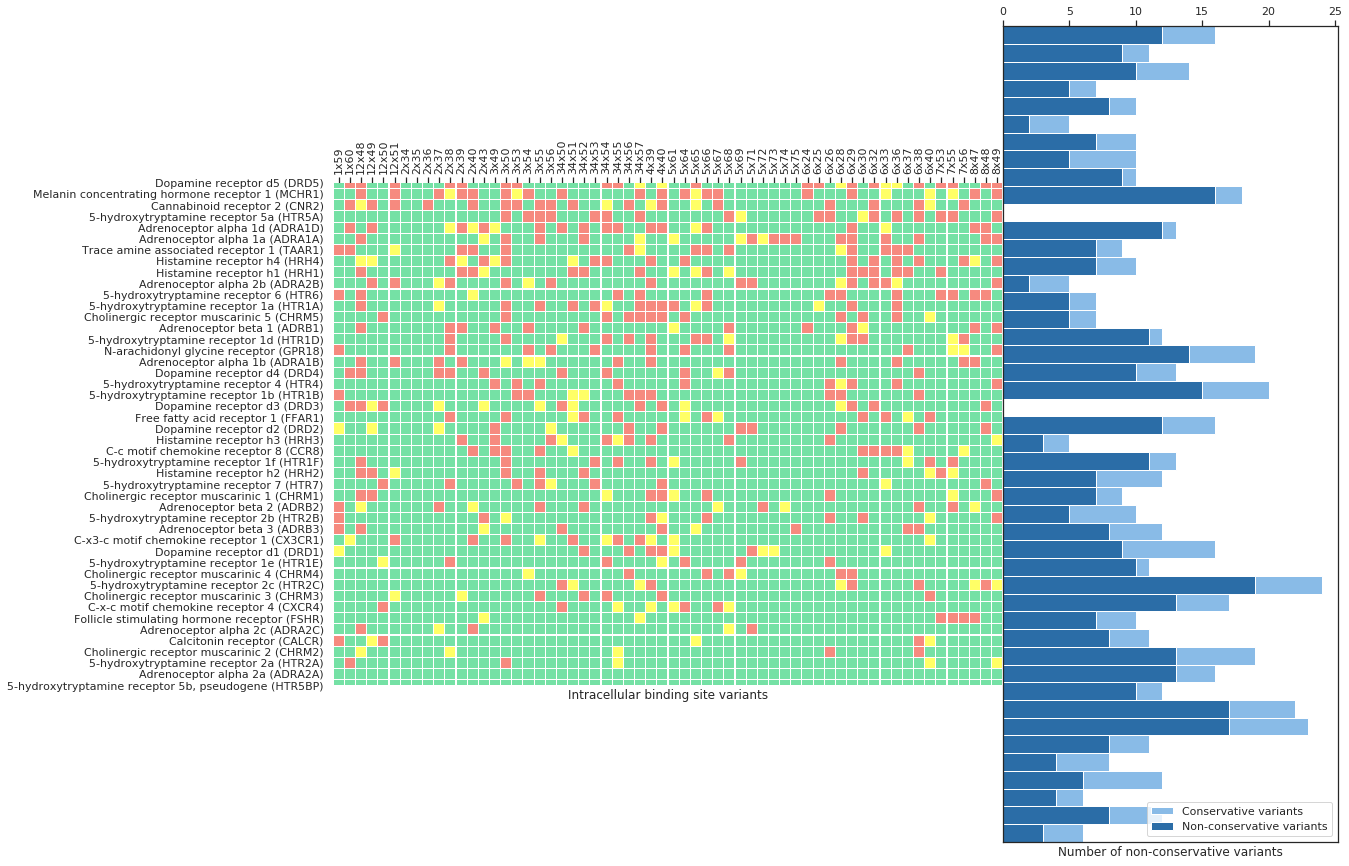

In [37]:
order_by_varnum=True
if order_by_varnum:# this doesnt apply to the the barcplot
    (gpcr_ibspos,gpcr_ibspos_count_df,all_gpcrs_axes)=sorted_var_info(gpcr_ibspos,gpcr_ibspos_count_df)
    
grid = plt.GridSpec(2, 2, wspace=0, hspace=0, width_ratios=[2, 1])
plt.figure(figsize=(18,30))

ax=plt.subplot(grid[0, 0])
#f, axs = plt.subplots(grid[0, 0],figsize=(15,15))
axA=sns.heatmap(gpcr_ibspos, cmap=["#75E1A5","#ffff66","#F68A7F"], linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
axA.xaxis.set_ticks_position('top')
axA.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
axA.xaxis.set_label_text("Intracellular binding site variants")

ax2=plt.subplot(grid[0, 1])
axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#79bcf7",label="Conservative variants")
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of non-conservative variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

ax3=plt.subplot(grid[0, 1])
axB = sns.barplot(data=gpcr_ibspos_count_cons_df , x="Count",y="GPCR",color="#166fbc",label="Non-conservative variants")
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of non-conservative variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

plt.legend()
plt.show()

### Clustering

In [38]:
gpcr_ibspos=cluster_df(gpcr_ibspos)

sorter=gpcr_ibspos.index
gpcr_ibspos_count_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_df)
gpcr_ibspos_count_cons_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_cons_df)
gpcr_ibspos_count_all_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_all_df)

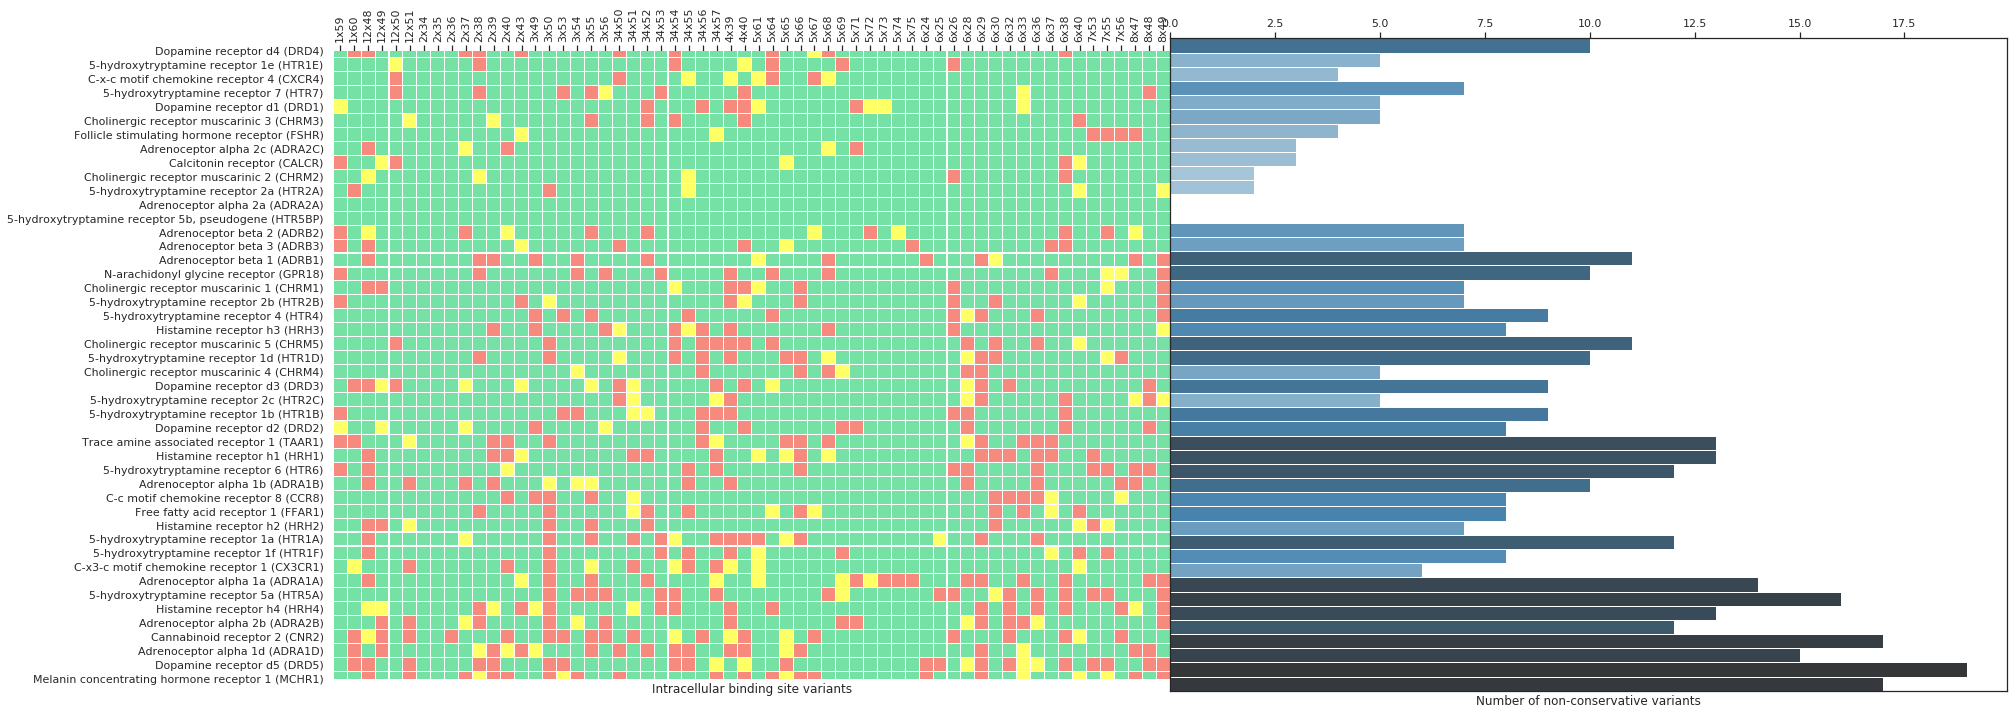

In [39]:
#gpcr_ibspos
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,12))
axA=sns.heatmap(gpcr_ibspos, cmap=["#75E1A5","#ffff66","#F68A7F"], linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax[0])
axA.xaxis.set_ticks_position('top')
axA.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
axA.xaxis.set_label_text("Intracellular binding site variants")
#axA.xaxis.set_label_position('top') 

#gpcr_bspos_count_df 
pal = sns.color_palette("Blues_d", len(gpcr_ibspos_count_df))
rank = gpcr_ibspos_count_df["Count"].argsort().argsort() 
axB = sns.barplot(data=gpcr_ibspos_count_df , x="Count",y="GPCR",palette=np.array(pal[::-1])[rank])
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of non-conservative variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [40]:
gpcr_ibspos_count_all_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_all_df)
gpcr_ibspos_count_cons_df=order_df_by_sorterlist(sorter,gpcr_ibspos_count_cons_df)

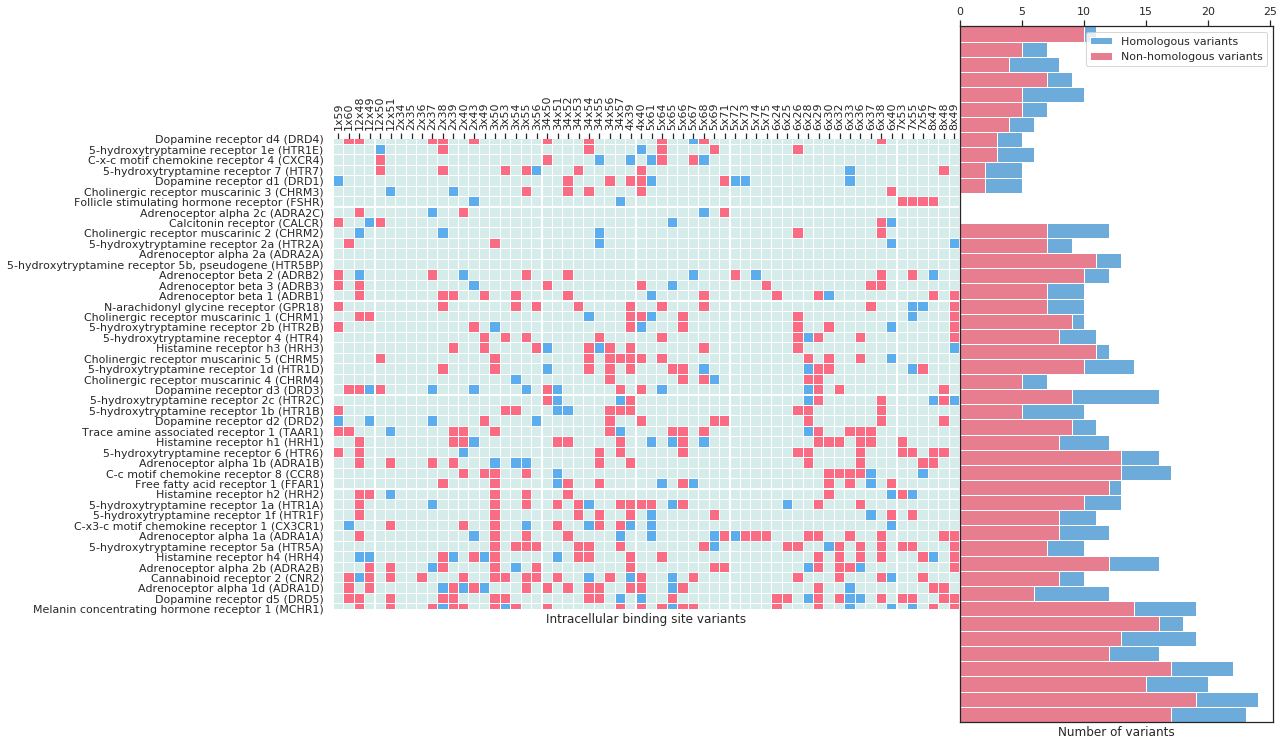

<Figure size 432x288 with 0 Axes>

In [41]:
cmap=["#75E1A5","#ffff66","#F68A7F"]
cmap=["#D5ECEB","#5BADED","#F96C84"]
grid = plt.GridSpec(2, 2, wspace=0, hspace=0, width_ratios=[2, 1])
plt.figure(figsize=(18,20))

ax=plt.subplot(grid[0, 0])
#f, axs = plt.subplots(grid[0, 0],figsize=(15,15))
axA=sns.heatmap(gpcr_ibspos, cmap=cmap, linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax)
axA.xaxis.set_ticks_position('top')
axA.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
axA.xaxis.set_label_text("Intracellular binding site variants")
#axA.xaxis.set_label_position("top")

ax2=plt.subplot(grid[0, 1])
axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#5BADED",label="Homologous variants")
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

ax3=plt.subplot(grid[0, 1])
axB = sns.barplot(data=gpcr_ibspos_count_cons_df , x="Count",y="GPCR",color="#F96C84",label="Non-homologous variants")
axB.get_yaxis().set_visible(False)
axB.xaxis.set_major_formatter(FormatStrFormatter('%.f'))

axB.xaxis.set_label_text("Number of variants")
axB.xaxis.set_ticks_position('top')
#axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

plt.legend()
plt.tight_layout()

plt.show()
plt.savefig("/home/martalo/Documentos/TFM/GPCR_variants/Results/Intracel_Binding_site/ibs_affected_clustered.png")

Count of variants in the IBS

In [42]:
gpcr_ibspos_count_bybs_all=dict(zip(inner_binding_site_gnum,[0]*len(inner_binding_site_gnum)))
gpcr_ibspos_count_bybs_noncons=dict(zip(inner_binding_site_gnum,[0]*len(inner_binding_site_gnum)))

for ibspos in gpcr_ibspos_count_bybs_all.keys():
    count_all=len([varval for varval in gpcr_ibspos[ibspos].values if varval> 0])
    count_noncons=len([varval for varval in gpcr_ibspos[ibspos].values if varval> 1])
    gpcr_ibspos_count_bybs_all[ibspos]=count_all
    gpcr_ibspos_count_bybs_noncons[ibspos]=count_noncons

gpcr_ibspos_count_bybs_all_df=pd.DataFrame(list(gpcr_ibspos_count_bybs_all.items()),
                      columns=['IBS pos','Count'])
gpcr_ibspos_count_bybs_noncons_df=pd.DataFrame(list(gpcr_ibspos_count_bybs_noncons.items()),
                      columns=['IBS pos','Count'])


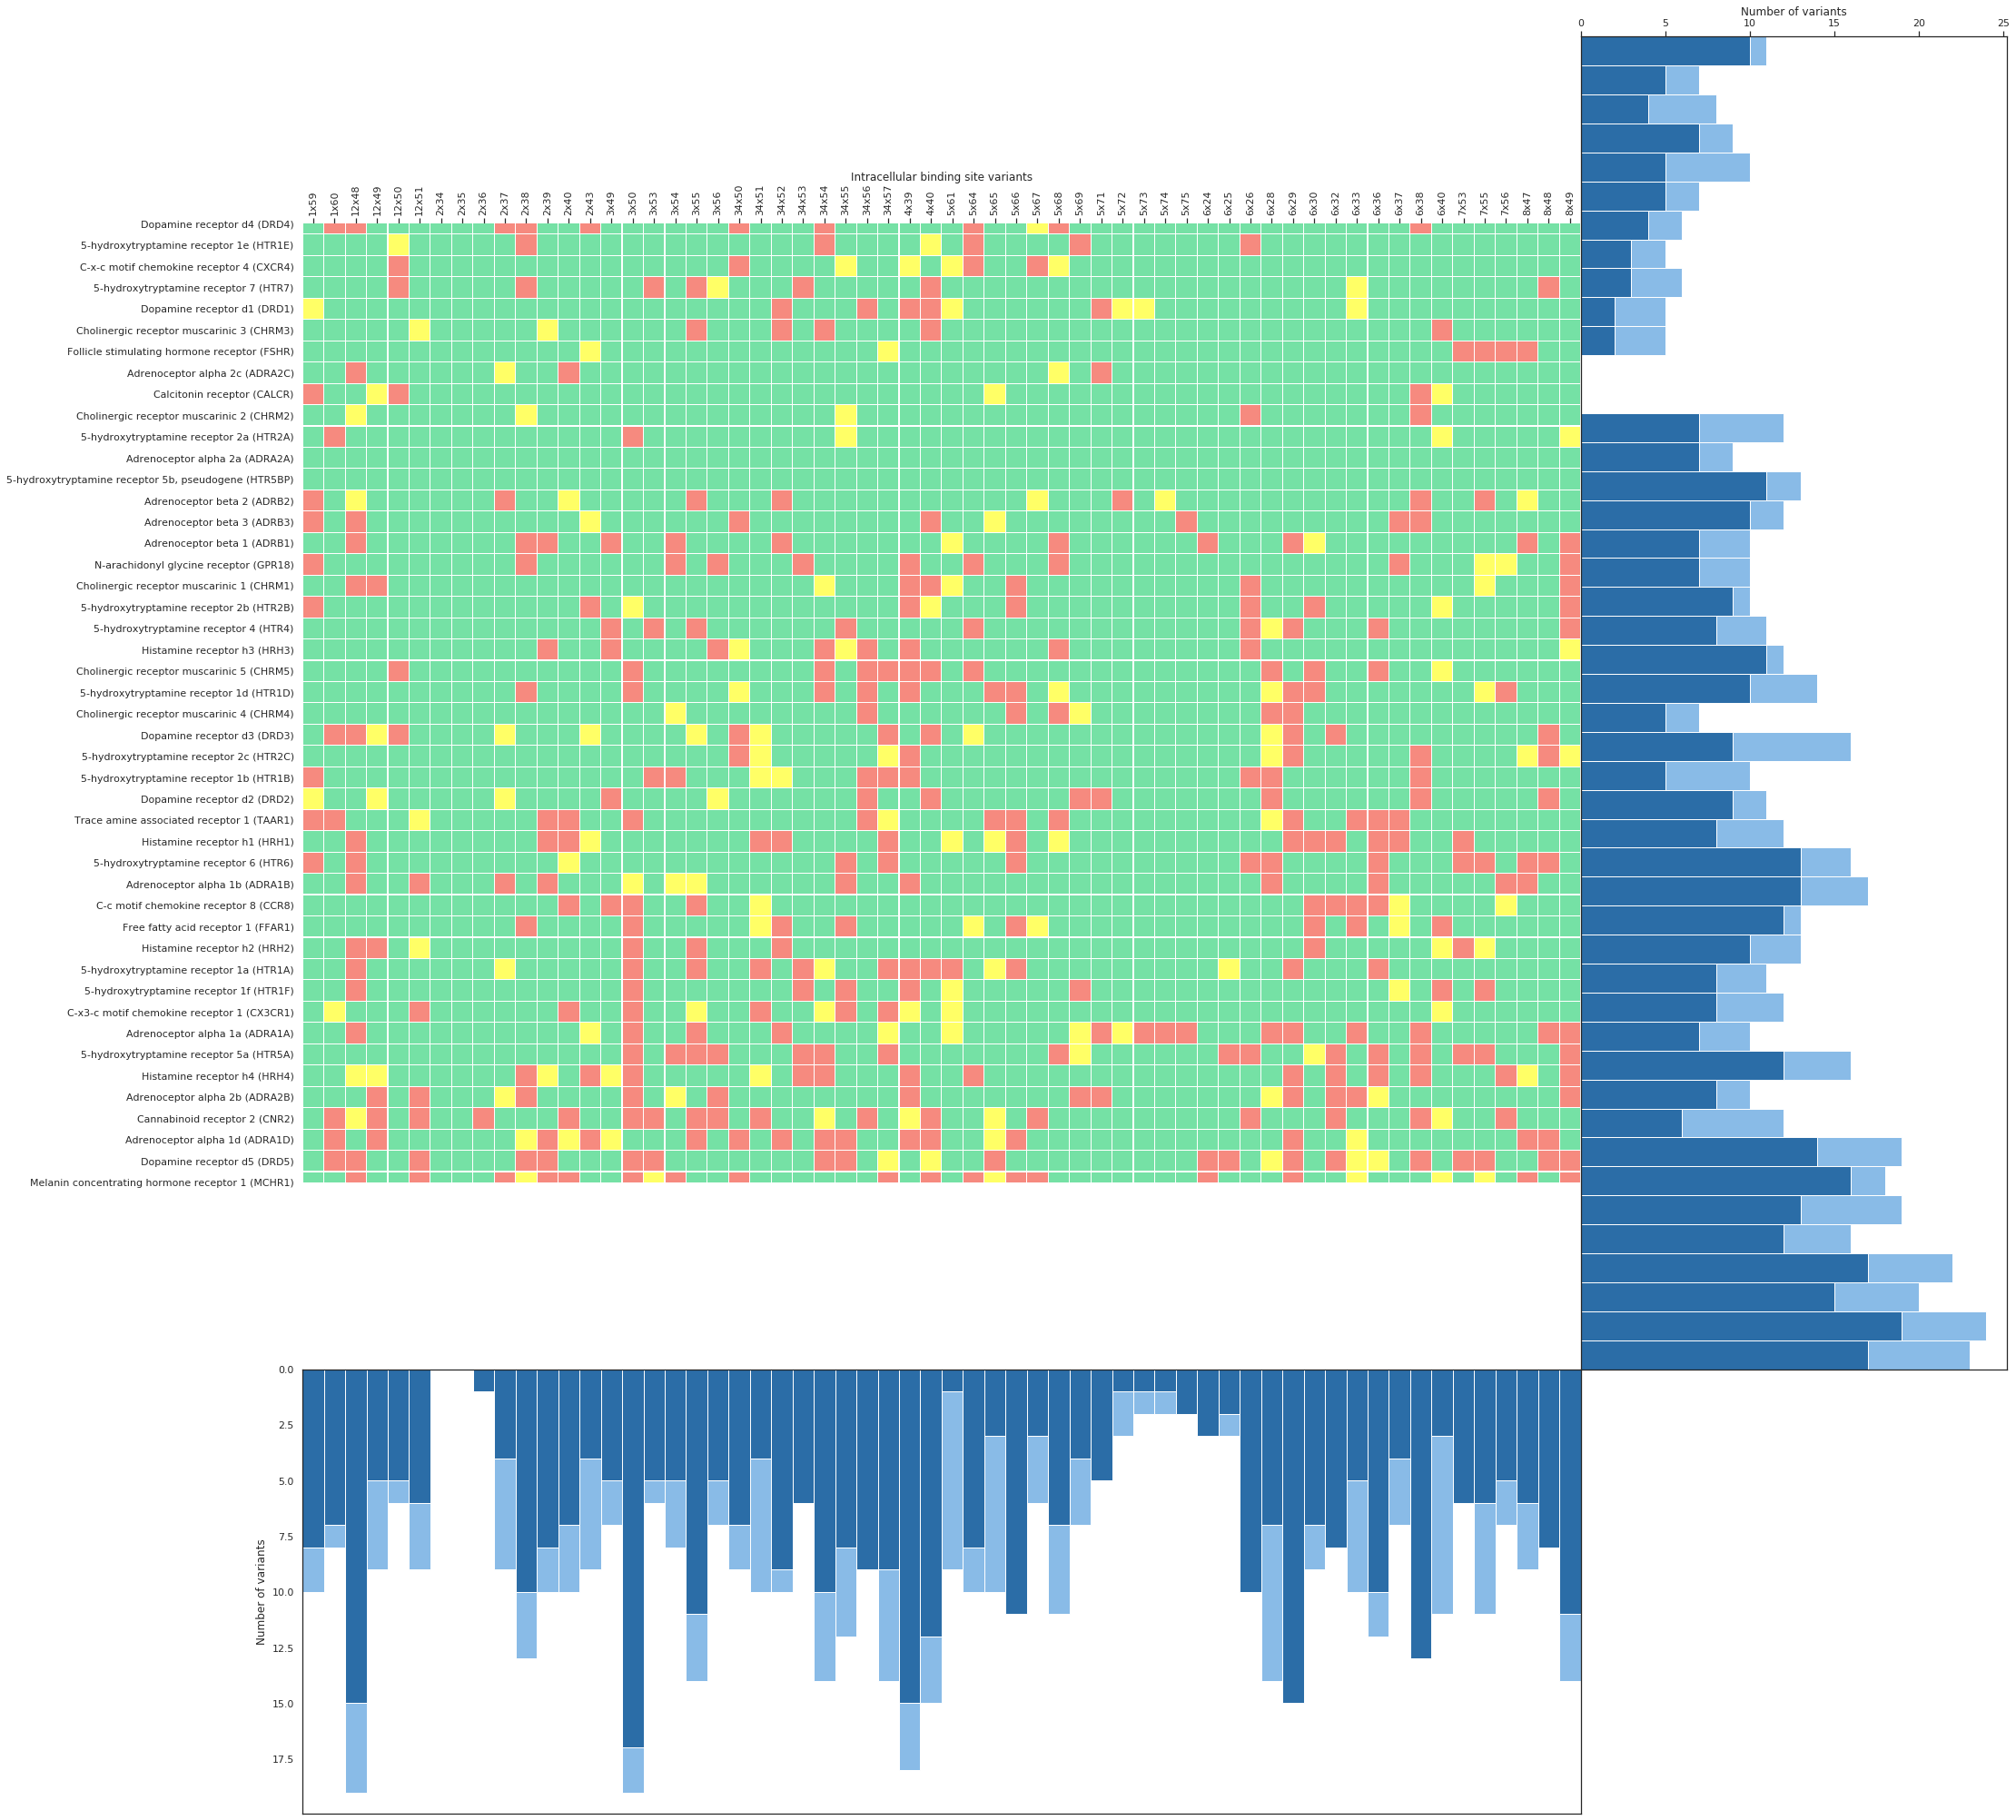

In [43]:

grid = plt.GridSpec(4,4, wspace=0, hspace=0)
#plt.figure(figsize=(59,75))
plt.figure(figsize=(31,28))
ax1=plt.subplot(grid[:-1, :-1])
axA=sns.heatmap(gpcr_ibspos, cmap=["#75E1A5","#ffff66","#F68A7F"], linewidths=0.1, annot=False, cbar=False,square=True,xticklabels=True, yticklabels=True,ax=ax1)
axA.xaxis.set_ticks_position('top')
axA.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
axA.xaxis.set_label_text("Intracellular binding site variants")
axA.xaxis.set_label_position("top")

ax2=plt.subplot(grid[:-1, -1])
axB = sns.barplot(data=gpcr_ibspos_count_all_df , x="Count",y="GPCR",color="#79bcf7",label="Conservative variants",ax=ax2)
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of variants")
axB.xaxis.set_ticks_position('top')
axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

ax2=plt.subplot(grid[:-1, -1])
axB = sns.barplot(data=gpcr_ibspos_count_cons_df , x="Count",y="GPCR",color="#166fbc",label="Non-conservative variants",ax=ax2)
axB.get_yaxis().set_visible(False)
axB.xaxis.set_label_text("Number of variants")
axB.xaxis.set_ticks_position('top')
axB.xaxis.set_label_position('top') 
change_width_h(axB, 1)

ax3=plt.subplot(grid[-1, :-1])
axB = sns.barplot(data=gpcr_ibspos_count_bybs_all_df , y="Count",x="IBS pos",color="#79bcf7",label="Conservative variants",ax=ax3)
axB.get_xaxis().set_visible(False)
axB.yaxis.set_label_text("Number of variants")
axB.invert_yaxis()
change_width_v(axB, 1)

ax3=plt.subplot(grid[-1, :-1])
axB = sns.barplot(data=gpcr_ibspos_count_bybs_noncons_df , y="Count",x="IBS pos",color="#166fbc",label="Non-conservative variants",ax=ax3)
axB.get_xaxis().set_visible(False)
axB.yaxis.set_label_text("Number of variants")
#axB.invert_yaxis()
change_width_v(axB, 1)
plt.tight_layout()

plt.show()

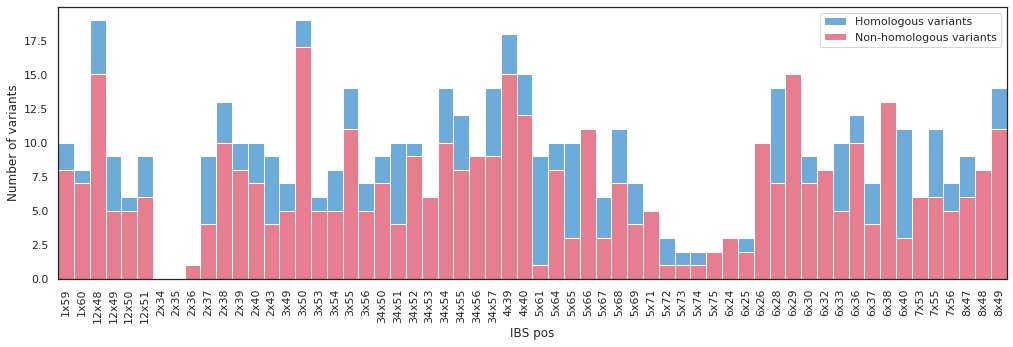

<Figure size 432x288 with 0 Axes>

In [44]:
#cmap=["#D5ECEB","#5BADED","#F96C84"]

fig, ax = plt.subplots(figsize=(17,5))
axB = sns.barplot(data=gpcr_ibspos_count_bybs_all_df , y="Count",x="IBS pos",color="#5BADED",label="Homologous variants",ax=ax)
axB.set_xticklabels(labels=gpcr_ibspos.columns , rotation=90)
#axB.get_xaxis().set_visible(False)
axB.yaxis.set_label_text("Number of variants")
#axB.invert_yaxis()
change_width_v(axB, 1)

axB = sns.barplot(data=gpcr_ibspos_count_bybs_noncons_df , y="Count",x="IBS pos",color="#F96C84",label="Non-homologous variants",ax=ax)
#axB.get_xaxis().set_visible(False)
axB.yaxis.set_label_text("Number of variants")
change_width_v(axB, 1)
plt.legend()
plt.show()
plt.savefig("/home/martalo/Documentos/TFM/GPCR_variants/Results/Intracel_Binding_site/ibs_count_positions.png")

# Interesting positions to mutate and simulate of the Intracellular Binding Site
We have seen than position 12x48 of the Intracellular Binding Site is the one with more non-homologous variants (and interacting with the secondary chain of the G protein) so we will store the info of those variants in two files.
1. First we will store the 'short info', that is ex: {'affected_pred': False, 'affected_items_pred': [], 'pdb_pos': {'aa': 'V', 'pos': '31', 'chain': 'A'}, 'gpcr_num': '1x36', 'aa_type_changed': False} -> obtained with the function 'var_to_display'. We will store this info of all the non-homolous varians detected in position 12x48 of the 46 GPCRs (15).

In [48]:
resultspath_var="/home/martalo/Documentos/TFM/GPCR_variants/Results/studied_GPCR_vars/filtered_var_list"
pp=re.compile(".*\((\w*)\)")

# Print 'short' info of the non-homologous variant in a file
with open(os.path.join(resultspath_var,'myvar_list_ibs_short.txt'), 'w') as outfile:
    for gpcrname in all_gpcrs_axes:# iteration over the 46 GPCRs
        gpcr_ibs=re.search(pp,gpcrname).group(1) # search and store the short names of the GPCRS        
        gpcr_vars_ibs=var_to_display(ex_gpcr=gpcr_ibs,dictpath=dictpath_vars) # function in 'create_csv',
        # returns list of variats for the GPCR 'gpcr_cm' (short info, organized) 
        if gpcr_vars_ibs:# if there are variants in the GPCR
            potential_vars={}
            for var in gpcr_vars_ibs:# iteration over the variants of the GPCR
                gnum_ibs=var["gpcr_num"] # store the position of the variant
                var_type_ibs=var["aa_type_changed"]
                if gnum_ibs=='12x48'and var_type_ibs:
                    outfile.write(json.dumps(var))
outfile.close()    

No pdb found for HTR5BP


2. Now, we will store the 'long info' of the same variants in another file. Ex: {'gpcrdb': '3.50x50', 'seqN': '134', 'var_aa': 'R', 'wt_aa': 'S', 'sift_poloP': True, 'DisGeNet_disease': False, 'gprotInt': True, 'arrestinInt': True, 'activation': False, 'microSwitch': True, 'sodiumP': False, 'ptm': False, 'interact': False}

In [49]:
#write the non-homologous variant 'long info' of positions 
with open(os.path.join(resultspath_var,'myvar_list_ibs_long.txt'), 'w') as outfile:
    for gpcrname in all_gpcrs_axes:# iteration over the 46 GPCRs
        gpcr=re.search(pp,gpcrname).group(1) # search and store the short names of the GPCRS        
        outfile.write(json.dumps(var_to_display_in_file('12x48',gpcr))) # write dictionary in the file


DRD5
{'gpcrdb': '12.48x48', 'seqN': '69', 'var_aa': 'R', 'wt_aa': 'G', 'sift_poloP': True, 'DisGeNet_disease': False, 'gprotInt': True, 'arrestinInt': False, 'activation': False, 'microSwitch': False, 'sodiumP': False, 'ptm': False, 'interact': False}
MCHR1
{'gpcrdb': '12.48x48', 'seqN': '138', 'var_aa': 'S', 'wt_aa': 'P', 'sift_poloP': True, 'DisGeNet_disease': False, 'gprotInt': True, 'arrestinInt': False, 'activation': False, 'microSwitch': False, 'sodiumP': False, 'ptm': False, 'interact': False}
CNR2
HTR5A
ADRA1D
ADRA1A
{'gpcrdb': '12.48x48', 'seqN': '55', 'var_aa': 'R', 'wt_aa': 'Q', 'sift_poloP': True, 'DisGeNet_disease': False, 'gprotInt': True, 'arrestinInt': False, 'activation': False, 'microSwitch': False, 'sodiumP': False, 'ptm': False, 'interact': False}
TAAR1
HRH4
HRH1
{'gpcrdb': '12.48x48', 'seqN': '56', 'var_aa': 'R', 'wt_aa': 'W', 'sift_poloP': True, 'DisGeNet_disease': False, 'gprotInt': True, 'arrestinInt': False, 'activation': False, 'microSwitch': False, 'sodiumP':